<a id="Titanic/Kaggle - Full analysis"></a>
# <span style="color:teal;font-weight:bold;">Titanic/Kaggle -Full analysis</span> 🕵🏽

Hi there! Welcome to a <span style="font-weight:bold;">deep study</span> for the <span style="font-style:italic;">Titanic - Machine Learning from Disaster</span> competition. I'll walk you through <span style="font-weight:bold;">data correction</span>, <span style="font-weight:bold;">feature engineering</span>, <span style="font-weight:bold;">correlation analysis</span>, <span style="font-weight:bold;">architecture design for ML algorithms</span> and <span style="font-weight:bold;">hyperparameters optimization</span>.

And very important... I'll show you my <span style="font-weight:bold;"><ins>results according to the Submission scoring</ins></span>, not just the internal training scores, which can be misleading. Spoiler alert! <span style="font-weight:bold;">My best ML model scored 0.7990</span> when making a <span style="font-weight:bold;">Submission</span>... I'll explain you how I considered many combinations of models and subsets of features to achieve this result.

I hope you enjoy the notebook, I've tried to be as clear as possible and to include all relevant details and explanations so you can understand my reasoning and coding. Have fun!

<hr>

# <font color='teal'>Outline</font> <a class="anchor"  id="Outline"></a>

* [**Introduction: scores, motivation and expectations**](#Introduction)

    - [Perfect scores and the Solution File](#Perfect_scores)
    
    - [Bibliography](#Bibliography)
    

* [**Section I: True facts and initial guesses**](#Section_I)
    
    - [Titanic: True facts](#True_facts)
    
    - [Initial guesses](#Initial_guesses)
    

* [**Section II: Data analysis**](#Section_II)

    - [Original features](#Original_features)
    
    - [Data edition: dealing with missing values](#Data_edition)
    
    - [Engineered features](#Engineered_features)
    
    - [Feature encoding (turn numeric)](#Feature_encoding)
    
    - [Feature correlations](#Feature_correlations)
    

* [**Section III: Machine learning models**](#Section_III)

    - [General training](#General_training)
    
    - [Model optimization](#Model_optimization)
    

* [**Section IV: Conclusions**](#Section_IV)

<hr>

# <font color='teal'>Introduction: scores, motivation and expectations</font> <a class="anchor"  id="Introduction"></a>

Let's say you build a machine learning (ML) model using a particular set of features to predict which passengers survived the Titanic disaster. You submit your results and get a score of 0.7756... is it a good result? <span style="font-weight:bold;">What reference value should you compare it to?</span> Should you aim for 0.9999? I've asked myself all these questions, and over many days, weeks (months?), I became more and more aware of my expectations...

First of all, any result you get is a step forward, it means you are actively working to solve the problem. Second point: a perfect score 1 (or 0.9999) is unrealistic for ML solutions... we're not trying to solve a problem governed by precise laws of Physics, instead <span style="font-weight:bold;">we're dealing with a complex situation that involves some degree of uncertainty</span>. That said,  it's still important to establish a reasonable benchmark for the accuracy that we expect. Although I don't have an analytical way to determine that reference score, we can take a look at the <span style="font-weight:bold;">statistics available in the public Leaderboard</span> (updated on 20/Jul/2024, 17,700 submissions):

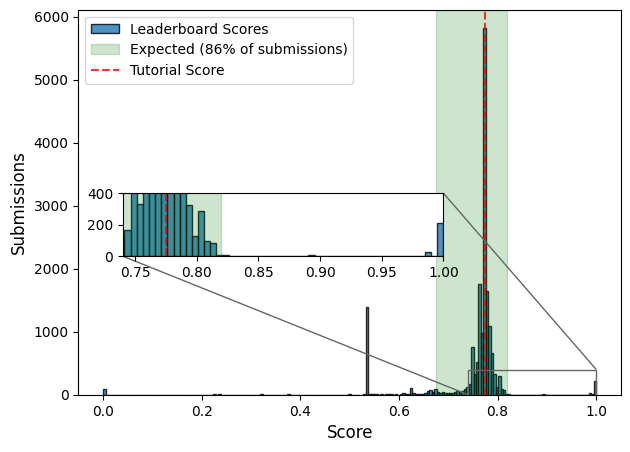

In [1]:
# Load leaderboard scores:
import pandas as pd
LB_file = "titanic-fm/titanic-publicleaderboard-2024-07-20.csv"
LB_scores = pd.read_csv(LB_file)['Score'] # Scores (fractions from 0 to 1)
# Set reference values and calculate the percentaje of scores between them:
min_expect = 1502/2224 # Baseline score, based on the tutorial's information
high_expect = 0.82 # High score according to kagglers' comments
tutorial_score = 0.775 # Score using the model from the official Titanic tutorial
in_btw = sum(LB_scores.between(min_expect,high_expect))/len(LB_scores)*100 # % of submissions between ref. values

# Plot scoring histogram with zoomed-in region:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig, ax = plt.subplots(figsize=(7,5))
# Full image:
hist = LB_scores.hist(bins=201,alpha=0.8,grid=False,edgecolor='black',
                      label='Leaderboard Scores',ax=ax)
ax.axvspan(min_expect, high_expect, alpha=0.2, color='green',
           label=f'Expected ({int(in_btw)}% of submissions)')
ax.axvline(tutorial_score,ls='--',lw=1.5,color='r',
           label='Tutorial Score',alpha=0.8)
ax.set_xlabel('Score',fontsize=12), ax.set_ylabel('Submissions',fontsize=12)
plt.legend()
# Zoomed-in image:
axins = zoomed_inset_axes(ax, 2.5, loc=6, bbox_to_anchor=[125,200,50,50])
hist_ins = LB_scores.hist(bins=201,alpha=0.8,grid=False,edgecolor='black',
                          label='Leaderboard Scores',ax=axins)
axins.axvspan(min_expect, high_expect, alpha=0.2, color='green')
axins.axvline(tutorial_score,ls='--',lw=1.5,color='r',
              label='Tutorial Score',alpha=0.8)
axins.set_xlim(0.74, 1), axins.set_ylim(0, 400)
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.4") # Lines for inset image
plt.show()

A few observations here:
* The <span style="color:blue;font-weight:bold;">raw data</span> for the scores is represented by the <span style="color:blue;font-weight:bold;">blue bars</span>, showing that scores are concentrated between 0.75 and 0.80. The scoring interval [0.7725, 0.7775] has the most submissions, approximately 6,000! 
* The <span style="color:red;font-weight:bold;">red vertical line</span> shows the <span style="color:red;font-weight:bold;">tutorial score</span> 0.7750, in which a simple model with the original features is implemented.
* The <span style="color:green;font-weight:bold;">shaded green area</span> indicates <span style="color:green;font-weight:bold;">typical expected scores</span>, with 86% of all submissions, according to the following criteria:
    - For a minimum expectation, consider building a model that always predicts that a passenger does not survive. Because we know that 1502 out of 2224 passengers didn't survive, the average accuracy will be 1502/2224=0.675.
    - For the highest expected score, I've chosen a 0.82 score based on the performance of other Kagglers' notebooks and their comments.

<hr>

## <font color='teal'>Perfect scores and the Solution File</font> <a class="anchor"  id="Perfect_scores"></a>

<span style="font-weight:bold;">Is it possible to get a perfect score 1?</span> Since the Titanic is a "Getting Started" competition and you can submit your solutions multiple times (with some daily limits), in principle you could explore all possible survival combinations until you get the right one. Or, to save time, you could just use the Solution File! <span style="font-weight:bold;">If you look around the Kagglers' comments, you will eventually find the link to the <a href="https://storage.googleapis.com/kaggle-forum-message-attachments/66979/2180/titanic.csv">Solution file</a></span> .

That explains <span style="font-weight:bold;">why there are some so many perfect scores in the Leaderboard...</span> But don't let these unfair results discourage you, the Titanic competition is meant to be a learning experience, and it's up to each one how to spend their time. <span style="font-weight:bold;">In fact, this Notebook is going to use the solution file!</span> Not for cheating, but <span style="font-weight:bold;">to accelerate research and get immediate feedback</span> on the various features and ML models that I'm going to explore. So when I share my Submission scores, now you know how.

<hr>

## <font color='teal'>Bibliography</font> <a class="anchor"  id="Bibliography"></a>

<span style="font-weight:bold;">Infinite thanks to all the Kagglers that share their works</span>, I've learned a lot from them and implemented many ideas. I cite the ones that inspired me the most:

* ANISOTROPIC: *Introduction to Ensembling/Stacking in Python*. Citation code: <a href="https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python">[ANI]</a>.
* GUNES EVITAN: *Titanic - Advanced Feature Engineering Tutorial*. Citation code: <a href="https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial">[GUN]</a>.
* LD FREEMAN: *A Data Science Framework: To Achieve 99% Accuracy*. Citation code: <a href="https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy">[LD]</a>.
* MANAV SEHGAL: *Titanic Data Science Solutions*. Citation code: <a href="https://www.kaggle.com/code/startupsci/titanic-data-science-solutions">[MAN]</a>.
* SAKSHAM PARASHAR: *Titanic Solution EDA + Estimator 1%*. Citation code: <a href="https://www.kaggle.com/code/sakshamparashar/titanic-solution-eda-estimator-1">[SAK]</a>.
* SUBIN AN: *Awesome Visualization with Titanic Dataset*. Citation code: <a href="https://www.kaggle.com/code/subinium/awesome-visualization-with-titanic-dataset">[SUB]</a>.
* TARUN PAPARAJU: *Titanic Competition: How top LB got their score*. Citation code: <a href="https://www.kaggle.com/code/tarunpaparaju/titanic-competition-how-top-lb-got-their-score">[TAR]</a>.
* YASSINE GHOUZAM: *Titanic Top 4% with ensemble modeling*. Citation code: <a href="https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling">[YAS]</a>.

For information about <span style="font-weight:bold;">true facts of the Titanic tragedy</span>, I've used the following sources:

* <a href="https://www.kaggle.com/c/titanic/overview">Kaggle</a>
* <a href="https://en.wikipedia.org/wiki/Sinking_of_the_Titanic">Wikipedia</a>
* <a href="https://www.history.com/topics/early-20th-century-us/titanic">History</a>
* <a href="https://www.noaa.gov/gc-international-section/rms-titanic-history-and-significance">National Oceanic and Atmospheric Administration</a>
* <a href="https://titanicfacts.net/titanic-maiden-voyage/">Titanic Facts</a>

<hr>

# <font color='teal'>Section I: True facts and initial guesses</font> <a class="anchor"  id="Section_I"></a>

Have you watched the Titanic movie, or heard about the tragedy before? It's very likely that you have, and that you've <span style="font-weight:bold;">started this challenge with some biases and preconcepts</span>, such as children and women given priority when boarding the lifeboats. 

<span style="font-weight:bold;">Biases and previous ideas can help you understand the problem</span> and offer hints in the right direction, <span style="font-weight:bold;">but they can also obscure reality or be misleading</span>. For this reason, I'll describe some true facts about the Titanic tragedy, as well as my expectations and initial guesses. While I aim to analyze the data objectively and extract conclusions from there, I'm aware that the starting point can significantly influence the entire process.

<hr>

## <font color='teal'>Titanic: True facts</font> <a class="anchor"  id="True_facts"></a>

* <span style="font-weight:bold;">The Titanic started its voyage in Southampton (UK) on 10 April 1912</span>, made a stop in Cherbourg (France) on the same day and a stop in Queenstown (nowadays Cobh, Ireland) on 11 April 1912. The ship <span style="font-weight:bold;">sank in the Atlantic ocean on 15 April 1912</span>, not arriving to its final destination: New York (USA).

* <span style="font-weight:bold;">The collision with the iceberg ocurred around 23:40</span>, with most of the passengers already gone to bed, meaning that the accident was surprising for them. After the collision, <span style="font-weight:bold;">the evacuation was carried out in a very disorganized way</span>, with unequal treatment of passengers from different classes: the first-class stewards actively assisted their passengers, guiding them out onto the deck, while the second- and third-class stewards mainly focused on throwing open doors and announcing that passengers needed to wear lifebelts and come up top, without mentioning that the ship was sinking.

* By the beginning of the evacuation, few third-class passengers had made it up onto the deck, and most were still lost in the maze of corridors or <span style="font-weight:bold;">trapped behind gates that segregated the third-class sections from the first- and second-class areas</span>.

* The Captain ordered to "put the women and children in the lifeboats and lower away". The two officers in charge of the evacuation interpreted the order in different ways: either 'women and children *first*' or 'women and children *only*'. Consequently, some boats included a limited number of men and <span style="font-weight:bold;">others were lowered with only women and children, even if there were empty seats</span>.

* <span style="font-weight:bold;">The Titanic sank in 2 hours and 40 minutes, around 2:20. The 20 lifeboats carried by the Titanic could only accomodate 1,178 people</span>. Almost all of those who jumped or fell into the sea drowned or died within minutes due to the effects of cold shock. The vessel RMS Carpathia arrived about 2 hours after the sinking, rescuing all survivors at that time.

The following timeline has been adapted from <a href="https://www.kaggle.com/code/subinium/awesome-visualization-with-titanic-dataset">[SUB]</a>:

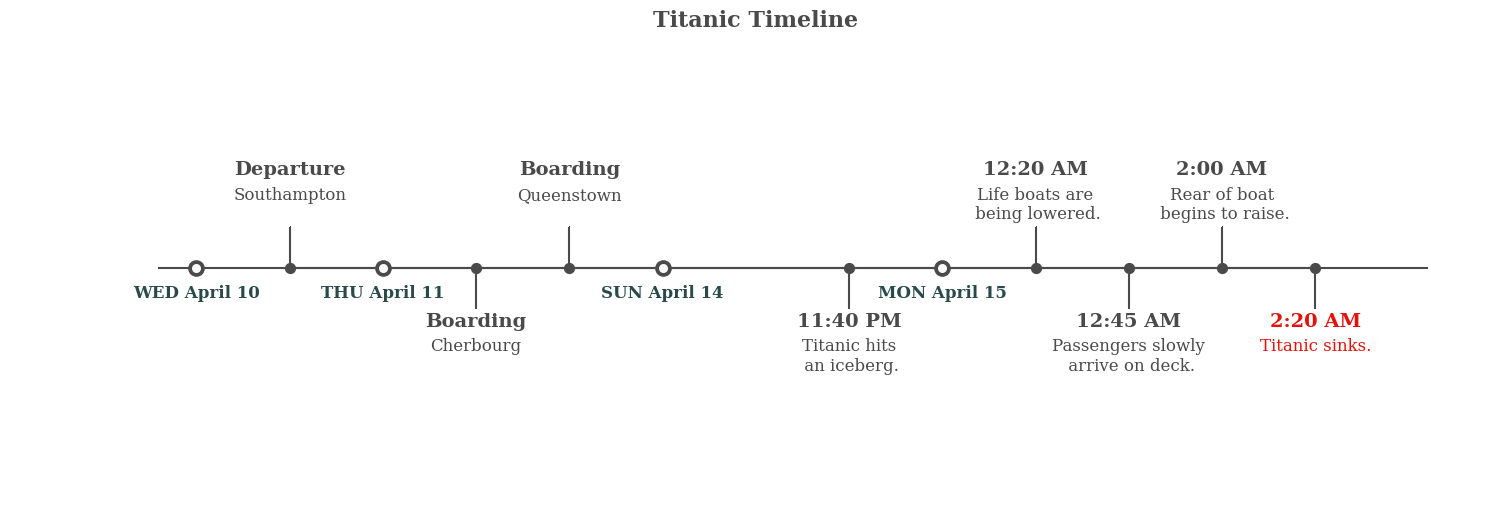

In [2]:
from datetime import datetime
import numpy as np

# Define dates by specifying their labels and coordinates along the timeline:
tl_dates = {"WED April 10": 1, "THU April 11": 2,
            "SUN April 14": 3.5, "MON April 15": 5}

# Define events by specifying their labels, category and coordinates:
tl_events = {
    "Southampton": ["Departure", 1.5], # April 10
    "Cherbourg": ["Boarding", 2.5], # April 11
    "Queenstown": ["Boarding", 3.0], # April 11
    "Titanic hits\n an iceberg.": ["11:40 PM", 4.5], # April 14
    "Life boats are\n being lowered.": ["12:20 AM", 5.5], # April 15
    "Passengers slowly\n arrive on deck.": ["12:45 AM", 6.0], # April 15
    "Rear of boat\n begins to raise.": ["2:00 AM", 6.5], # April 15
    "Titanic sinks.": ["2:20 AM", 7.0] # April 15
}

# Set figure and axes:
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
ax.set_ylim(-2, 2), ax.set_xlim(0, 8)

# Main timeline structure:
ax.axhline(0, xmin=0.1, xmax=0.95, c='#4a4a4a', zorder=1) # Line
ax.scatter(tl_dates.values(), np.zeros(len(tl_dates)), s=120, c='#4a4a4a', zorder=2) # Main data points, outer
ax.scatter(tl_dates.values(), np.zeros(len(tl_dates)), s=30, c='#fafafa', zorder=3) # Main data points, inner 
ax.scatter([date for label, date, in tl_events.values()], np.zeros(len(tl_events)), 
           s=50, c='#4a4a4a',zorder=4) # Events' points

# Labels for dates:
for date in tl_dates:
    ax.text(tl_dates[date], -0.25, date, ha='center', fontsize=12,
            fontfamily='serif', fontweight='bold', color='#2a4a4a')

# Vertical lines for events:
levels = np.ones(len(tl_events))*0.35
levels[1::2] *= -1
markerline, stemline, baseline = ax.stem([date for label, date, in tl_events.values()], levels)    
plt.setp(baseline, zorder=0)
plt.setp(markerline, marker=',', color='#4a4a4a')
plt.setp(stemline, color='#4a4a4a')

# Text for events:
for i, event in enumerate(tl_events):
    ax.text(tl_events[event][1],1.3*((i+1)%2)-0.5,tl_events[event][0], # Sub-event
            ha='center', fontfamily='serif', fontweight='bold',
            color='#4a4a4a' if (i+1)!=len(tl_events) else '#e3120b', fontsize=14)
    ax.text(tl_events[event][1], 1.3*((i+1)%2)-0.6, event, va='top', # Event
            ha='center', fontfamily='serif', fontsize=12,
            color='#4a4a4a' if (i+1)!=len(tl_events) else '#e3120b')

# Set invisible spines and ticks
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]), ax.set_yticks([])

# Set title:
ax.set_title("Titanic Timeline", fontweight="bold", fontfamily='serif', fontsize=16, color='#4a4a4a')

plt.show()

* There were 2,224 people aboard the Titanic, including passengers and crew. Of these, 722 survived, meaning a <span style="font-weight:bold;">survival rate of 32.5%</span>. While not all sources agree in the exact numbers, I will follow the official Kaggle information.

* The **survival rates** for the different classes and crew are estimated as follows:<ol>     
    <p> <span style="font-weight:bold;">1st class: 60.5%</span>. </p>
    <p> <span style="font-weight:bold;">2nd class: 41.7%</span>. </p>
    <p> <span style="font-weight:bold;">3rd class: 24.5%</span>. </p>
    <p> <span style="font-weight:bold;">Crew: 23.8%</span>. </p> 
    </ol>

* Grouping by main categories Children/Women/Men, and then by subcategories, the survival rates are:<ol>
    <p> <span style="font-weight:bold;">Children: 51%</span>. 1st class: 83% ; 2nd class: 100% ; 3rd class: 34%. </p>
    <p> <span style="font-weight:bold;">Women: 74%</span>. 1st class: 97% ; 2nd class: 86% ; 3rd class: 54% ; Crew: 87%. </p>
    <p> <span style="font-weight:bold;">Men: 20%</span>. 1st class: 33% ; 2nd class: 8% ; 3rd class: 16% ; Crew: 22%. </p> 
    </ol>

<hr>

## <font color='teal'>Initial guesses</font> <a class="anchor"  id="Initial_guesses"></a>

Based on the previous facts, I made my <span style="font-weight:bold;">first guesses</span> for survival chances for individuals aboard the Titanic:

* <span style="font-weight:bold;">**Women and children** have better chances of survival compared to men</span>. I would have thought that children had the best chance, but according to the statistics their survival rate is 51%, compared to the 74% rate for women. <span style="font-weight:bold;">Then: women first, children second, men third</span>.

* <span style="font-weight:bold;">**Wealth** improves the survival chances</span>, which can be measured by the passenger-class. However, the previous "rule" (women-->children-->men) takes priority, meaning that the <span style="font-weight:bold;">best chances for survival are for rich women and children</span>. For future analysis, women and children from first- and second-class might be group together, as their survival rates are similar.

* The **location in the ship at the time of collision** may play an important role, as the sinking was relatively fast and the evacuation process very disorganized. <span style="font-weight:bold;">Those who arrived earlier probably had better chances for survival</span>.

These guesses may help with feature engineering. Next, I describe the <span style="font-weight:bold;">features</span> provided in the datasets and qualify them as <span style="color:green;font-weight:bold;">important</span>, <span style="color:gray;font-weight:bold;">undetermined</span> or <span style="color:red;font-weight:bold;">irrelevant</span>:
<ol>    
    <li> <span style="color:red;font-weight:bold;">PassengerId</span>: Artificial feature to identify passengers by numbers, it shouldn't have any importance.
    </li>  
    <li> <span style="color:green;font-weight:bold;">Pclass</span>: Wealth indicator, probably essential for survival predictions. If combined with other feature(s) that separate women/children/men, it could be even more effective.
    </li>
    <li> <span style="color:green;font-weight:bold;">Name</span>: This feature includes two pieces of information: the passenger's full name and their prefix. The family name can help establish kinship relationships, though there's a risk of missasignment with common surnames. On the other hand, the prefix can encode a lot of information, such as:     
        <br>
        <p> - Age (e.g. 'Master' for male children). </p>
        <p> - Gender (e.g. 'Mr' vs. 'Miss'). </p>
        <p> - Wealth (e.g. 'Lady'). </p>
        <p> - Marital status (e.g. 'Miss' vs. 'Mrs'). </p>
        <p> - Role in the ship (e.g. 'Capt'). </p>
        While the prefix information may overlap with other features like <span style="font-weight:bold;">Sex</span>, <span style="font-weight:bold;">Age</span> or <span style="font-weight:bold;">Pclass</span>, but it can help complete missing values.
    </li>        
    <li> <span style="color:green;font-weight:bold;">Sex</span>: Gender indicator, probably crucial for survival predictions based on the 'rule' women-->children-->men.
    </li>
    <li> <span style="color:green;font-weight:bold;">Age</span>: Based on the 'rule' women-->children-->men, it could be extremely useful to identify children. For adult passengers, being young or old may play a role for survival.
    </li>
    <li> <span style="color:gray;font-weight:bold;">SibSp</span> (Number of siblings/spouses aboard the Titanic): Do members of a family unit share the same fate? Or perhaps they prioritize saving at least one individual... I don't have a clear expectation for this feature.
    </li>
    <li> <span style="color:gray;font-weight:bold;">Parch</span> (Number of parents/children aboard the Titanic): Same reasoning as <span style="font-weight:bold;">SibSp</span>.
    </li>    
    <li> <span style="color:gray;font-weight:bold;">Ticket</span>: The ticket number alone doesn't appear to be informative, but an additional prefix is sometimes included, such as 'A/5' or 'STON/O2.'. It's likely related to the embarkation location or the passenger's room.
    </li>
    <li> <span style="color:green;font-weight:bold;">Fare</span>: Wealth indicator, it could help establish a hierarchy within each <span style="font-weight:bold;">Pclass</span> category. However, it's worth noting that there are some '0' fare values for passengers belonging to either first-, second- or third-class.
    </li>
    <li> <span style="color:gray;font-weight:bold;">Cabin</span>: This feature could be definitively useful according to the 'location in the ship at the time of collision' guess. However, about 80% of the <span style="font-weight:bold;">Cabin</span> values are missing, in both training and testing datasets. 
    </li>
    <li> <span style="color:gray;font-weight:bold;">Embarked</span>: In principle, I don't expect a clear correlation between the embarkation location and the survival chance.
    </li>
</ol>

<hr>

# <font color='teal'>Section II: Data analysis</font> <a class="anchor"  id="Section_II"></a>

According to my initial guesses, only a few of the original features may have a significant impact for survival predictions. However, <span style="font-weight:bold;">there may be hidden correlations</span>, invisible to the human intuition, that a ML model can exploit. Therefore, I won't limit the analysis to my priviledged features, instead I'll try to <span style="font-weight:bold;">explore the features space as throughly as possible</span>.

<hr>

## <font color='teal'>Original features</font> <a class="anchor"  id="Original_features"></a>

I begin by <span style="font-weight:bold;">loading the original training and testing datasets</span>, and examining a few lines:

In [3]:
import os

# Check files: training 'train.csv', testing 'test.csv' and solutions 'test_labels.csv'
for dirname, _, filenames in os.walk('titanic-input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load original datasets:
train_df_orig = pd.read_csv('titanic-input/train.csv') # Training dataset
test_df_orig = pd.read_csv('titanic-input/test.csv') # Testing dataset

# Extract PassengerId and remove it from datasets:
passID_train = train_df_orig['PassengerId']
passID_test = test_df_orig['PassengerId']
train_df_orig = train_df_orig.drop('PassengerId',axis=1)
test_df_orig = test_df_orig.drop('PassengerId',axis=1)

# Print some data examples:
train_df_orig.head()

titanic-input/gender_submission.csv
titanic-input/train.csv
titanic-input/test.csv


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Display <span style="font-weight:bold;">basic information</span> about both training and testing datasets:

In [4]:
# Get information about datasets:
print('_'*40+'\n\nTRAINING DATASET:\n')
train_df_orig.info()
print('_'*40+'\n\nTESTING DATASET:\n')
test_df_orig.info()

________________________________________

TRAINING DATASET:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
________________________________________

TESTING DATASET:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 no

From this information, we can make a few observations:

* <span style="font-weight:bold;">Both datasets share the **same features**, except for **Survived**</span> (ground truth) in the training dataset.

* The number of rows are 891 and 418 in the training and testing datasets, respectively, <span style="font-weight:bold;">totalling 1309 passengers</span>: a subset of the 2224 people on board.

* Only **Pclass**, **Age**, **SibSp**, **Parch** and **Fare** are <span style="font-weight:bold;">numerical</span> features.

* The following features are <span style="font-weight:bold;">complete</span> in both datasets: **Name**, **Sex**, **SibSp**, **Parch**, **Ticket**.

* Among the <span style="font-weight:bold;">incomplete</span> features: **Age** has $\approx$80% non-null values in both datasets; **Fare** has only 1 missing value in the testing dataset; **Cabin** has $\approx$20% non-null values in both datasets; **Embarked** has only 2 missing values in the training dataset.

For a better understanding of each feature, I plot the <span style="font-weight:bold;">distribution of values (column 1)</span> in both training and testing datasets; and the <span style="font-weight:bold;">survival rates</span> for the training dataset <span style="font-weight:bold;">(column 2)</span>. Also, <span style="font-weight:bold;">some features are explicitely explained in a table</span>, when they have only a few unique values.

*Note: Since the features **Name**, **Ticket** and **Cabin** are string-type and have too many unique values, I ignore them in this description.*

The following hidden lines define the plotting functions, inspired on <a href="https://www.kaggle.com/code/subinium/awesome-visualization-with-titanic-dataset">[SUB]</a>, and the summary tables.

In [5]:
# Define plotting functions:
import seaborn as sns
from IPython.display import display

def plot_dist_pie(df_train,df_test,feature,axis):
    """
    Plot a pie chart for the distribution of values from a single feature in both training
    and testing datasets.
    --- Inputs ---
    {df_train, df_test}. Type: pandas dataframe. Definition: training and testing datasets.
    Both datasets must include the column with the input name {feature}.
    {feature}. Type: string. Definition: name of the column (feature) to be analyzed.
    {axis}. Type: matplotlib axis object. Definition: axis for the current subplot.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    train_data, test_data = df_train[feature], df_test[feature]
    train_counts = train_data.value_counts().sort_index()
    test_counts = test_data.value_counts().sort_index()
    # Plot pie chart, start with the outer ring:
    axis.pie(train_counts, colors=sns.color_palette('Set2'),
             labels=train_counts.keys(),labeldistance=0.8,
             startangle=90,frame=True,explode=np.ones(len(train_counts))*0.01)
    # Add white ring to separate training and testing pies:
    axis.add_artist(plt.Circle((0,0),0.70,color='black', fc='white',linewidth=0))
    # Testing inner pie:
    axis.pie(test_counts, colors=sns.color_palette('Set2'),
             labels=test_counts.keys(),labeldistance=0.6,
             radius=0.5,startangle=90,explode=np.ones(len(test_counts))*0.01)
    # Add white central circle to complete the pie:
    axis.add_artist(plt.Circle((0,0),0.25,color='black', fc='white',linewidth=0))
    # Set legend (available data) and title:
    axis.legend([f'Train (outer): {np.round(train_data.count()/len(train_data)*100,1)}%',
                 f'Test (inner): {np.round(test_data.count()/len(test_data)*100,1)}%'],
                title='Data availability',fontsize=8,title_fontsize=8)
    axis.set_title(f'{feature}: Distribution')
    
def plot_dist_hist(df_train,df_test,feature,axis,bin_step=None,hist_data=False):
    """
    Plot a histogram chart for the distribution of values from a single feature in both training
    and testing datasets.
    --- Inputs ---
    {df_train, df_test}. Type: dataframe (pandas). Definition: training and testing datasets.
    Both datasets must include the column with the input name {feature}.
    {feature}. Type: string. Definition: name of the column (feature) to be analyzed.
    {axis}. Type: matplotlib axis object. Definition: axis for the current subplot.
    {bin_step}. Type: integer or None. Definition: if provided, set the bins' step-value for
    the histogram, otherwise automatically assigned.
    """
    # Identify relevant data and calculate fraction of valid values:
    train_data, test_data = df_train[feature], df_test[feature]
    train_frac = np.round(train_data.count()/len(train_data)*100,1) # [%]
    test_frac = np.round(test_data.count()/len(test_data)*100,1) # [%]
    # Determine binning, uniform for both datasets:
    min_range = min(min(train_data),min(test_data))
    max_range = max(max(train_data),max(test_data))
    if bin_step:
        binning = np.arange(min_range,max_range+bin_step*2,bin_step)-bin_step/2
    else:
        binning = np.linspace(min_range,max_range,10)
    # Bar plot:
    train_data.plot(kind='hist', bins=binning, edgecolor='navy', color='teal',
                    ax=axis, alpha=0.6)
    test_data.plot(kind='hist', bins=binning, edgecolor='navy', color='orange',
                   ax=axis, alpha=0.6)
    axis.legend([f'Train: {train_frac}%',f'Test: {test_frac}%'],title='Data availability') # Set legend (available data)    
    axis.set_yticks([0,int(axis.get_ylim()[1])], minor=False)
    axis.set_xlabel(feature)
    axis.set_title(f'{feature}: Distribution')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)

def plot_surv_swarm(df_train,feature,axis,ref_feature='Survived',seed=42):
    """
    Plot a swarm plot ordered by the survival rate from a single feature in the training dataset.
    --- Inputs ---
    {df_train}. Type: dataframe (pandas). Definition: training dataset, must include the columns
    with names {feature} and {ref_feature}.
    {feature}. Type: string. Definition: name of the column (feature) to be analyzed.
    {ref_feature}. Type: string. Definition: name of the column (feature) by which {feature} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis}. Type: matplotlib axis object. Definition: axis for the current subplot.
    {seed}: Type: integer. Definition: seed for random scattering in swarm plots.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    train_data = df_train[feature] # Training dataset    
    train_counts = train_data.value_counts().sort_index()
    # For each variable, identify the survival rate and build the swarm plot:
    np.random.seed(seed) # Random seed for swarm plots
    for i, var in enumerate(train_counts.keys()):
        # Determine points' location:
        surv_rate = df_train.groupby([feature]).mean(numeric_only=True)[ref_feature].loc[var] # Survival rate
        pp_pos = int(len(df_train[(df_train[feature]==var)])*surv_rate) # Positive survival values
        pp_neg = int(len(df_train[(df_train[feature]==var)])*(1-surv_rate)) # Negative survival values
        var_pos = np.random.uniform(0, surv_rate,pp_pos) # Randomly assign locations for "positive" points
        var_neg = np.random.uniform(surv_rate,1,pp_neg) # Randomly assign locations for "negative" points              
        # Allocate all points in plot:
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_neg)), var_neg,s=10,
                     color='#004c70', edgecolor='lightgray', alpha=0.2, label=f'{var}({ref_feature}=0)')
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_pos)), var_pos,s=10,
                     color='#004c70', edgecolor='lightgray', label=f'{var}({ref_feature}=1)')
    # Ticks and limits:
    axis.set_xlim(-0.5, len(train_counts)-0.5)
    axis.set_ylim(-0.03, 1.1)
    axis.set_xticks(np.linspace(0,len(train_counts.keys())-1,len(train_counts.keys())))
    axis.set_xticklabels(train_counts.keys(), fontweight='bold', fontfamily='serif', fontsize=13)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('')
    # Spines, legend and title:
    for s in ["top","right","left", 'bottom']:
        axis.spines[s].set_visible(False)
    axis.legend([0,1],title=ref_feature,loc=(0.8, 0.7), edgecolor='k')
    axis.set_title(f'{feature}: "{ref_feature}" rate (Train)')

import warnings # <sns.kdeplot> gives a warning I couldn't fix, I avoid displaying it...
warnings.simplefilter(action='ignore', category=FutureWarning)
def plot_surv_KDE(df_train,feature,axis,ref_feature='Survived'):
    """
    Plot a kernel density estimate (KDE) plot ordered by the survival rate from a single feature in
    the training dataset.
    --- Inputs ---
    {df_train}. Type: dataframe (pandas). Definition: training dataset, must include the columns
    with names {feature} and {ref_feature}.
    {feature}. Type: string. Definition: name of the column (feature) to be analyzed.
    {ref_feature}. Type: string. Definition: name of the column (feature) by which {feature} will
    be analyzed. This feature must be binary with values 0 and 1. Default: 'Survived'.
    {axis}. Type: matplotlib axis object. Definition: axis for the current subplot.
    """    
    train_data = df_train[feature] # Identify relevant data
    # Plot KDE:
    sns.kdeplot(x=feature, data=df_train, ax=axis, fill=True,cut=0,
                bw_method=0.15, lw=1.4, edgecolor='lightgray', hue=ref_feature,
                multiple="stack", palette='PuBu', alpha=0.8)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('Density [arb. units]')
    axis.set_title(f'{feature}: "{ref_feature}" rate (Train)')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)  

def explain_stats(df_train,feature,unique_vals_max=10):
    """
    Explain the distribution of values in a table format and the survival rates for
    the training dataset.
    --- Inputs ---
    {df_train}. Type: dataframe (pandas). Definition: training dataset, must include the columns
    with names {feature} and {ref_feature}.
    {feature}. Type: string. Definition: name of the column (feature) to be analyzed.
    {unique_vals_max}: Type: Integer. Definition: Maximum number of unique values for the feature.
    If there are more than this limit, there won't be any output table. Default: 10.
    """
    # Check the unique_vals_max condition (avoid NaN):
    unique_vals = {x for x in df_train[feature] if x == x} # Number of unique values
    if len(unique_vals) > unique_vals_max:
        print(f'There are {len(unique_vals)} unique values for this feature, more than the allowed limit ({unique_vals_max}).')
        return None    
    # Explained values:
    df_expl = pd.DataFrame(columns=[f'{feature}','#Passengers','Survival_Rate[%]'])
    df_expl[f'{feature}'] = sorted(unique_vals)
    df_expl['#Passengers'] = [len(df_train[df_train[f'{feature}'] == x])
                              for x in sorted(unique_vals)]
    # Survival rates for each feature category:
    df_expl['Survival_Rate[%]'] = [
        len(df_train[(df_train[feature] == x) & # Select fare range
            (df_train['Survived'] == 1)])/ # Passengers who survived
        len(df_train[(df_train[feature] == x)]) # Total passengers
        for x in sorted(unique_vals) # Iterate through all feature categories
    ]
    df_expl['Survival_Rate[%]'] *=100 # Convert from fraction to [%]
    print(f'Explained {feature} values and survival rates in training dataset:')
    display(df_expl.style.hide())

------------------------- Pclass -------------------------


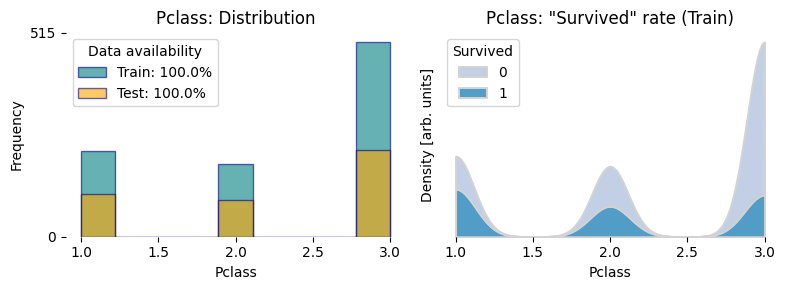

Explained Pclass values and survival rates in training dataset:


Pclass,#Passengers,Survival_Rate[%]
1,216,62.962963
2,184,47.282609
3,491,24.236253


------------------------- Fare -------------------------


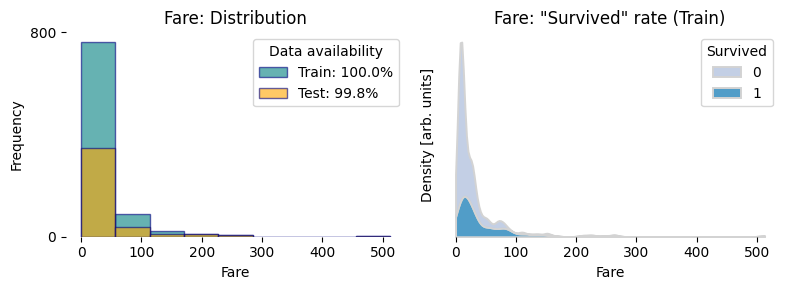

(Not suitable for a table)
------------------------- Sex -------------------------


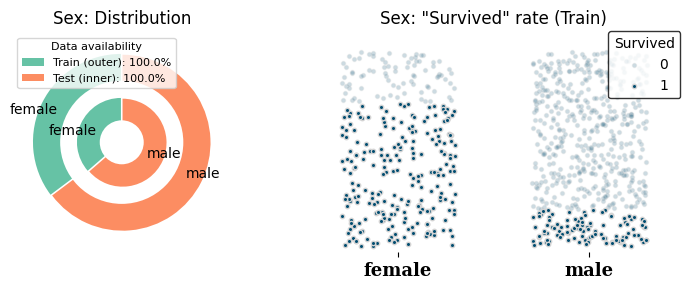

Explained Sex values and survival rates in training dataset:


Sex,#Passengers,Survival_Rate[%]
female,314,74.203822
male,577,18.890815


------------------------- Age -------------------------


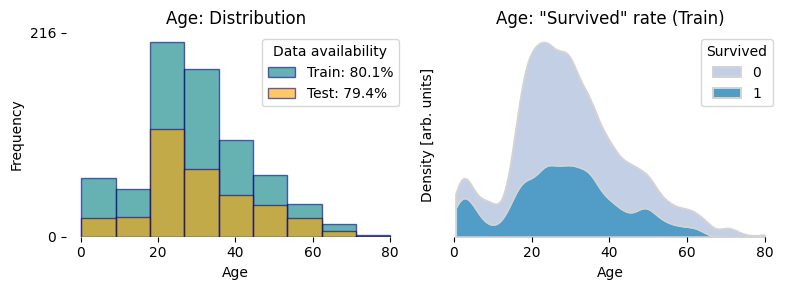

(Not suitable for a table)
------------------------- SibSp -------------------------


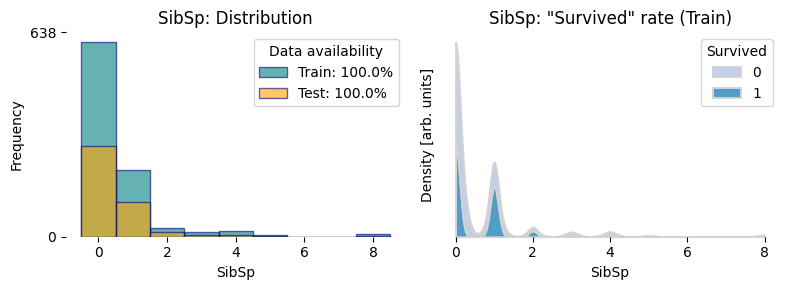

Explained SibSp values and survival rates in training dataset:


SibSp,#Passengers,Survival_Rate[%]
0,608,34.539474
1,209,53.588517
2,28,46.428571
3,16,25.000000
4,18,16.666667
5,5,0.000000
8,7,0.000000


------------------------- Parch -------------------------


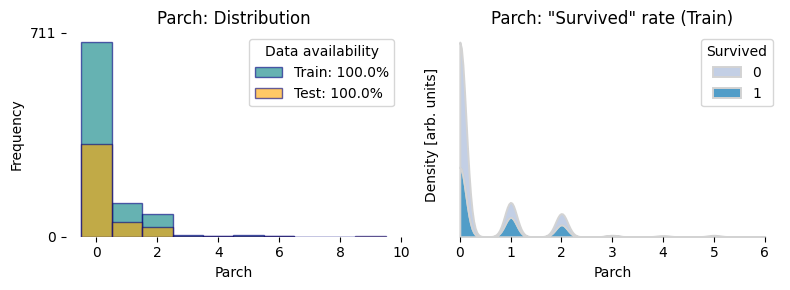

Explained Parch values and survival rates in training dataset:


Parch,#Passengers,Survival_Rate[%]
0,678,34.365782
1,118,55.084746
2,80,50.000000
3,5,60.000000
4,4,0.000000
5,5,20.000000
6,1,0.000000


------------------------- Embarked -------------------------


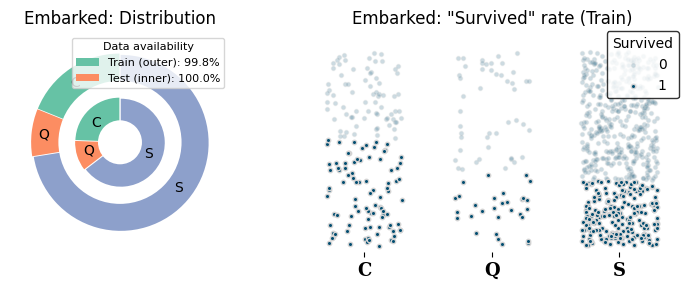

Explained Embarked values and survival rates in training dataset:


Embarked,#Passengers,Survival_Rate[%]
C,168,55.357143
Q,77,38.961039
S,644,33.695652


In [6]:
# Select features to analyze:
features = ['Pclass', 'Fare', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']

# Plot distribution of values and survival rates for each feature:
for feature in features:
    print('-'*25,feature,'-'*25)
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
    if train_df_orig[feature].dtype == 'object': # Non-numerical features:
        plot_dist_pie(train_df_orig,test_df_orig,feature,ax1)
        plot_surv_swarm(train_df_orig,feature,ax2)    
    else: # Numerical features:
        bin_step = 1 if feature in ['SibSp','Parch'] else None
        plot_dist_hist(train_df_orig,test_df_orig,feature,ax1,bin_step=bin_step)
        plot_surv_KDE(train_df_orig,feature,ax2)
    fig.tight_layout()
    plt.show()
    # Display explanatory table only if there are equal or less than 10 unique values:
    if len(set(train_df_orig[feature]))<=10:
        explain_stats(train_df_orig,feature)
    else:
        print('(Not suitable for a table)')

In the following table, I make some <span style="font-weight:bold;">comments about the distribution of values</span> (column 1 in plots) and the <span style="font-weight:bold;">survival chances</span>, by roughly analyzing the Survived vs. non-survived ratios (column 2 in plots):

| Feature | <font color=blue> Distribution comments </font> | <font color=green> Survival comments </font> |
| :---: | :--- | :--- |
| <span style="font-weight:bold;">Pclass</span> | <font color=blue> 3rd class has more passengers than 1st and 2nd classes altogether </font> | <font color=green> Survival chances increase with wealth </font> |
| <span style="font-weight:bold;">Fare</span> | <font color=blue> Complementary to <span style="font-weight:bold;">Pclass</span>: cheaper fares ($>$50) are most common, high fares ($<$100) are scarce </font> | <font color=green> Survival chances increase with wealth </font> |
| <span style="font-weight:bold;">Sex</span> | <font color=blue> Approximately 2/3 men, 1/3 women </font> | <font color=green> Low survival rate for men ($\approx$20%), high for women ($\approx$75%) </font> |
| <span style="font-weight:bold;">Age</span> | <font color=blue> 20-30 is the most popular range, the distribution slowly decays toward older ages </font> | <font color=green> 20-40 range has poor survival chances </font> |
| <span style="font-weight:bold;">SibSp</span> | <font color=blue> 0 is most common, followed by 1; higher values are not frequent. </font> | <font color=green> 1 Sib/Sp have better survival chances than 0 </font> |
| <span style="font-weight:bold;">Parch</span> | <font color=blue> Complementary to <span style="font-weight:bold;">SibSp</span>: 0 is most common; followed by 1 and 2; higher values are unusual </font> | <font color=green> At least 1 children/parent is better than 0 for survival </font> |
| <span style="font-weight:bold;">Embarked</span> | <font color=blue> Southampton is the most common ($\approx$2/3) embarkment place. </font> | <font color=green> Cherbourg has a $\approx$50% survival rate, while Southampton and Queenstown between 30-40% </font> |

<hr>

## <font color='teal'>Data edition: dealing with missing values</font> <a class="anchor"  id="Data_edition"></a>

As shown before, <span style="font-weight:bold;">not all features are 100% available</span>, and something must be done with the missing values. The notebooks <a href="https://www.kaggle.com/code/startupsci/titanic-data-science-solutions">[MAN]</a>, <a href="https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy">[LD]</a> and <a href="https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial">[GUN]</a> present excellent approaches for <span style="font-weight:bold;">correcting missing data</span>, which I follow for most of the features. 

Below, I describe the <span style="font-weight:bold;">editing process for each feature individually</span>. First, I generate new dataframes for the corrected data: 

In [7]:
train_df_corr, test_df_corr = train_df_orig.copy(), test_df_orig.copy()

<hr>

### <span style="color:teal;font-weight:bold;">Fare</span> <span style="color:teal">corrections</span> <a class="anchor"  id="Fare_corrections"></a>
There is only <span style="font-weight:bold;">1 missing value</span> in the testing dataset, for a passenger with **Pclass=3**:

In [8]:
idx = test_df_orig['Fare'].isnull() # Row index for the passenger with missing fare
print('-'*10+' Original data '+'-'*10)
test_df_orig.loc[idx] # Print that row

---------- Original data ----------


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


I consider **Pclass** the most relevant indicator here, so I <span style="font-weight:bold;">fill the **Fare** value with the median fare value for the subgroup **Pclass=3**</span>:

In [9]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
test_df_corr['Fare'] = test_df_corr.groupby(
    'Pclass',group_keys=False)['Fare'].apply(lambda x: x.fillna(x.median()))
# Check the result:
print('-'*10+' Corrected data '+'-'*10)
test_df_corr.loc[idx]

---------- Corrected data ----------


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,7.8958,NaN,S


<hr>

### <span style="color:teal;font-weight:bold;">Cabin</span> <span style="color:teal">corrections</span> <a class="anchor"  id="Cabin_corrections"></a>
There are <span style="font-weight:bold;">approximately 80% missing values in each dataset</span>, let's visualize the available information as a word cloud:

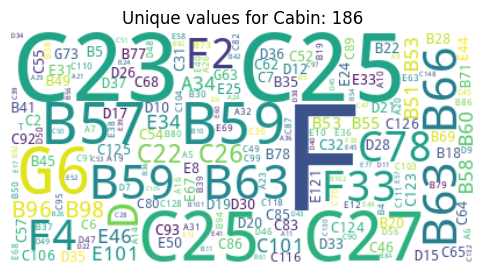

In [10]:
# Extract available information for 'Cabin' in both datasets:
cabin = list(train_df_orig['Cabin'].loc[~train_df_orig['Cabin'].isna()].values)+\
        list(test_df_orig['Cabin'].loc[~test_df_orig['Cabin'].isna()].values)
unique_vals = len(set(cabin)) # Number of unique values for Cabin

# Plot wordcloud with all values:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
cabin = " ".join(i for i in cabin) # Convert to adequate format
wordcloud = WordCloud(stopwords=[], background_color="white",random_state=2).generate(cabin)
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Unique values for Cabin: {unique_vals}")
plt.axis("off")
plt.show()

The Wordcloud plot shows that <span style="font-weight:bold;">every **Cabin** value contains a single letter and often includes a number</span> ranging from 1 to 3 digits. These <span style="font-weight:bold;">letters denote sections of the Titanic</span> and, as indicated in <a href="https://www.tota.world/article/3704/">Traditions of the Ancestors</a>, the passenger decks are ordered alphabetically from top to bottom:

<img src= "https://s3-us-west-2.amazonaws.com/tota-images/1628190806536-e629d92c849dec67.png" alt ="Titanic" style='width: 350px;'>

Information for the **Cabin** feature is scarce, so I will <span style="font-weight:bold;">simplify the data just to contain a letter</span> (section of the ship), ignoring the number (which probably indicates the room number). Based on my guessing about the **location in the ship at the time of collision**, I expect that the 'earlier' the letter (meaning closer to 'A'), the more chances of survival. 

<span style="font-style:italic;">Note: Some rows include more than one value, e.g. "B51 B53 B55" or "F G63", maybe because a family is occupying several cabins. Whenever there are mixed sections in a single value, I only compute the first instance.</span>

In [11]:
train_df_corr['Cabin'] = train_df_orig['Cabin'].str.get(0)
test_df_corr['Cabin'] = test_df_orig['Cabin'].str.get(0)

Regarding the numerous missing values, <a href="https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial">[GUN]</a> makes a remarkable observation: <span style="font-weight:bold;">missing Cabin values have the lowest survival rate because the cabin data couldn't be retrieved from the victims</span>. Then, labeling the missing data as a separate category could play a crucial role in the model predictions.

In here, I <span style="font-weight:bold;">replace the missing values by the letter 'X'</span> (different from any other cabin value):

In [12]:
train_df_corr['Cabin'] = train_df_corr['Cabin'].fillna(value='X')
test_df_corr['Cabin'] = test_df_corr['Cabin'].fillna(value='X')

Let's take a look at the <span style="font-weight:bold;">word cloud for the corrected data</span>:

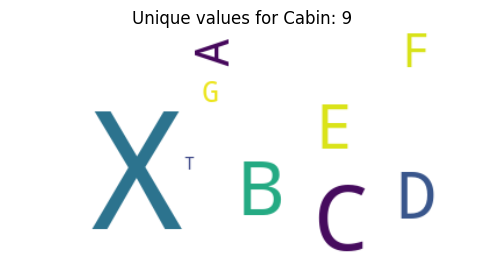

In [13]:
# Extract available information for 'Cabin' in both datasets:
cabin_corr = list(train_df_corr['Cabin'].loc[:].values)+list(test_df_corr['Cabin'].loc[:].values)
unique_vals_corr = len(set(cabin_corr)) # Number of unique values for Cabin

cabin_corr = " ".join(i for i in cabin_corr)
wordcloud = WordCloud(stopwords=[], background_color="white",random_state=1).generate(cabin_corr)
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Unique values for Cabin: {unique_vals_corr}")
plt.axis("off")
plt.show()

After editing the data, the <span style="font-weight:bold;">number of unique values reduced from 186 to 9</span>, which is much more suitable for machine learning applied to small datasets..

Notice that a <span style="font-weight:bold;">small 'T'</span> (size is indicative of counts) appears in the plot, which is <span style="font-weight:bold;">not included in the diagram of the ship</span>. In fact, 'T' only appears in the training dataset for one passenger:

In [14]:
print('-'*10+' Corrected training dataset '+'-'*10)
train_df_corr.loc[train_df_corr['Cabin']=='T']

---------- Corrected training dataset ----------


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


<span style="font-weight:bold;">Keeping a unique value won't benefit the ML model, so I'll assign it to any other category</span>. The decision taken by <a href="https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial">[GUN]</a> was to assign 'T' as 'A', since this passenger is first-class. Nevertheless, considering the cabins occupied by first class passengers, 'A' is actually the least frequent section:

In [15]:
print('Cabins occupied by first class passengers in training dataset:')
train_df_corr[train_df_corr['Pclass']==1]['Cabin'].value_counts()

Cabins occupied by first class passengers in training dataset:


Cabin
C    59
B    47
X    40
D    29
E    25
A    15
T     1
Name: count, dtype: int64

In absence of any clear trend, I <span style="font-weight:bold;">replace 'T' by 'X'</span> (the unknown):

In [16]:
train_df_corr.loc[train_df_corr['Cabin'] == 'T', 'Cabin'] = 'X' # Reassign cabin

After these steps, we have simplified the **Cabin** feature and completed missing values. Let's plot the <span style="font-weight:bold;">final distribution of values and the survival rates</span> in the training dataset:

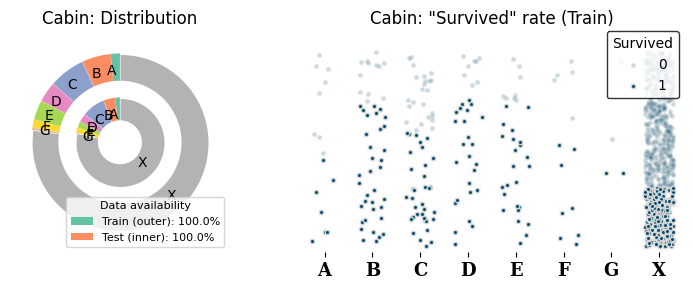

Explained Cabin values and survival rates in training dataset:


Cabin,#Passengers,Survival_Rate[%]
A,15,46.666667
B,47,74.468085
C,59,59.322034
D,33,75.757576
E,32,75.000000
F,13,61.538462
G,4,50.000000
X,688,29.941860


In [17]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure      
plot_dist_pie(train_df_corr.sort_values(by=['Cabin']),
              test_df_corr.sort_values(by=['Cabin']),'Cabin',ax1)
plot_surv_swarm(train_df_corr.sort_values(by=['Cabin']),'Cabin',ax2) 
fig.tight_layout()
plt.show()
explain_stats(train_df_corr,'Cabin')

Notice that <span style="font-weight:bold;">cabins 'G' and 'F'</span>, which are contiguous sections in the ship, have very <span style="font-weight:bold;">low counts</span> and <span style="font-weight:bold;">similar survival rates</span>. As a final edition step, I <span style="font-weight:bold;">group 'F' and 'G' under a new category 'H'</span>:

In [18]:
# Group cabins in training and testing datasets:
for cabin in ['F','G']:
    train_df_corr.loc[train_df_corr['Cabin'] == cabin, 'Cabin'] = 'H'
    test_df_corr.loc[test_df_corr['Cabin'] == cabin, 'Cabin'] = 'H'

<hr>

### <span style="color:teal;font-weight:bold;">Embarked</span> <span style="color:teal">corrections</span> <a class="anchor"  id="Embarked_corrections"></a>
<span style="font-weight:bold;">Only 2 passengers have missing values</span> for this feature, and they share the same **Ticket** number and **Cabin**, so I <span style="font-weight:bold;">assume that they embarked together</span>:

In [19]:
train_df_orig.loc[train_df_orig['Embarked'].isnull()] # Print that row

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


The distribution for embarkment location is dominated by Southampton ('S'), so <span style="font-weight:bold;">I fill the missing values with 'S'</span>:

In [20]:
train_df_corr['Embarked'] = train_df_orig['Embarked'].fillna('S')

<hr>

### <font color='teal'>Checkpoint 1</font> <a class="anchor"  id="Checkpoint_1"></a>

So far, <span style="font-weight:bold;">all missing values are corrected except for those in the **Age** feature</span>, which I will address later:

In [21]:
from termcolor import colored
print('Any missing values in the corrected training / testing datasets?')
for feature in test_df_corr.columns:
    # Count missing values:
    N_train = train_df_corr[feature].isna().sum() 
    N_test = test_df_corr[feature].isna().sum()
    # Print results:
    color_train = 'red' if N_train else 'green'
    color_test = 'red' if N_test else 'green'
    print(feature,':',colored(N_train, color_train),'/',colored(N_test, color_test))

Any missing values in the corrected training / testing datasets?
Pclass : 0 / 0
Name : 0 / 0
Sex : 0 / 0
Age : 177 / 86
SibSp : 0 / 0
Parch : 0 / 0
Ticket : 0 / 0
Fare : 0 / 0
Cabin : 0 / 0
Embarked : 0 / 0


<hr>

## <font color='teal'>Engineered features</font> <a class="anchor"  id="Engineered_features"></a>

In this section, I <span style="font-weight:bold;">generate engineered features based on the corrected datasets</span>:

| New Feature | <font color=blue> Foundations </font> | <font color=green> Description </font> |
| :---: | :--- | :--- |
| <span style="font-weight:bold;">Title</span> | <span style="color:blue;font-weight:bold;">Name</span> | <font color=green> Simplified title categories: "Mr", "Ms" "Mrs" and "Rare" </font> |
| <span style="font-weight:bold;">Age_Range</span> | <span style="color:blue;font-weight:bold;">Age</span> | <font color=green> Age intervals grouped every 9 years </font> |
| <span style="font-weight:bold;">Fare_Range</span> | <span style="color:blue;font-weight:bold;">Fare</span> | <font color=green> Logarithmic-scale intervals for fares, ranging from 1 (cheap) to 8 (expensive) </font> |
| <span style="font-weight:bold;">Family_Is_alone</span> | <span style="color:blue;font-weight:bold;">Patch, SibSp</span> | <font color=green> If the passenger is alone (True/False) </font> |
| <span style="font-weight:bold;">Family_size</span> | <span style="color:blue;font-weight:bold;">Patch, SibSp</span> | <font color=green> Number of family members in the ship, including oneself </font> |
| <span style="font-weight:bold;">Ocurr_Ticket</span> | <span style="color:blue;font-weight:bold;">Ticket</span> | <font color=green> Number of ocurrences for the ticket </font> |
| <span style="font-weight:bold;">Prefix_Ticket</span> | <span style="color:blue;font-weight:bold;">Ticket</span> | <font color=green> Main prefix in the ticket (before numbers), if any </font> |
| <span style="font-weight:bold;">Pcl_Age_Sex_surv</span> | <span style="color:blue;font-weight:bold;">Pclass, Age, Sex, Survived</span> | <font color=green> Inferred survival probability based on the training dataset </font> |

In between **Title** and **Age_Range**, I'll correct the missing values for the **Age** feature.

<hr>

### <span style="color:teal;font-weight:bold;">Title</span> <span style="color:teal">new feature</span> <a class="anchor"  id="Title_new_feature"></a>

The **Name** feature contains <span style="font-weight:bold;">information about the title of the passenger</span>, and all values are organized in the following format: *Last name, **Title** Name (if any: Maiden Name)*. Let's see a few examples:

In [22]:
train_df_orig['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

To <span style="font-weight:bold;">extract the title from each **Name** value</span>, I identify the first substring between space and dot characters. Then, I <span style="font-weight:bold;">summarize the counts for unique values</span> within each **Sex** category.

In [23]:
# Generate new feature:
train_df_corr['Title'] = train_df_orig.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df_corr['Title'] = test_df_orig.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# Summarize counts for unique values according to Sex categories:
print('\nCOUNTS FOR UNIQUE VALUES IN TRAINING DATASET:')
display(pd.crosstab(train_df_corr['Title'], train_df_corr['Sex']))
print('_'*40+'\nCOUNTS FOR UNIQUE VALUES IN TESTING DATASET:')
display(pd.crosstab(test_df_corr['Title'], test_df_corr['Sex']))


COUNTS FOR UNIQUE VALUES IN TRAINING DATASET:


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_148874/130101958.py:2: SyntaxWarning: invalid escape sequence '\.'
  train_df_corr['Title'] = train_df_orig.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
/tmp/ipykernel_148874/130101958.py:3: SyntaxWarning: invalid escape sequence '\.'
  test_df_corr['Title'] = test_df_orig.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


________________________________________
COUNTS FOR UNIQUE VALUES IN TESTING DATASET:


Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


Some observations about these tables:

* <span style="font-weight:bold;">Titles are exclusive for female or male</span>, with the only exception of 'Dr'.
* There are <span style="font-weight:bold;">few titles with high counts</span>: 'Mr', 'Miss', 'Mrs' and 'Master'. All others have no more than 10 values each.
* The training and testing datasets have different title categories, with <span style="font-weight:bold;">at least one title being exclusive to each dataset</span>. This discrepancy can pose a problem for training a machine learning model.
* <span style="font-weight:bold;">Some titles are equivalent</span> but spelled in a different way or language: 'Ms', 'Miss' and 'Mlle' all indicate an unmarried woman.

Although I could keep all categories for the new **Title** feature, <span style="font-weight:bold;">grouping all infrequent categories may work much better for the ML model</span>. I follow the approach used by <a href="https://www.kaggle.com/code/startupsci/titanic-data-science-solutions">[MAN]</a>:

* <span style="font-weight:bold;">Unify all equivalent titles</span> 'Miss', 'Ms', 'Mlle' and 'Mme' as 'Miss'.
* <span style="font-weight:bold;">Group all titles with few counts</span> (<10) in the "Rare" value.

In [24]:
for dataset in [train_df_corr,test_df_corr]:
    dataset['Title'] = dataset['Title'].replace(\
                        ['Ms', 'Mlle','Mme'],'Miss')
    dataset['Title'] = dataset['Title'].replace(\
                        ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major'\
                         , 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')

Now let's examine the <span style="font-weight:bold;">distribution of values and survival rates</span>:

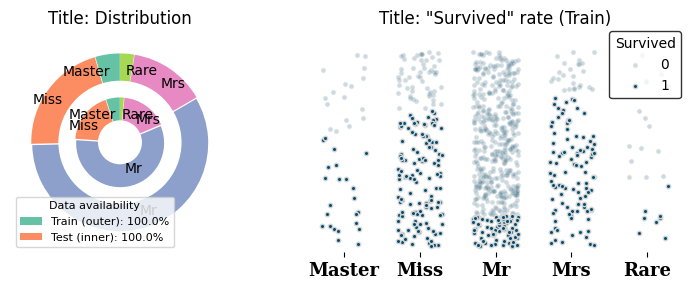

Explained Title values and survival rates in training dataset:


Title,#Passengers,Survival_Rate[%]
Master,40,57.500000
Miss,186,70.430108
Mr,517,15.667311
Mrs,125,79.200000
Rare,23,34.782609


In [25]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3))      
plot_dist_pie(train_df_corr.sort_values(by=['Title']),
              test_df_corr.sort_values(by=['Title']),'Title',ax1)
plot_surv_swarm(train_df_corr.sort_values(by=['Title']),'Title',ax2)    
fig.tight_layout()
plt.show()
explain_stats(train_df_corr,'Title')

<hr>

### <span style="color:teal;font-weight:bold;">Age</span> <span style="color:teal">corrections</span> <a class="anchor"  id="Age_corrections"></a>

It's time to come back to the <span style="font-weight:bold;">**Age** original feature</span> and <span style="font-weight:bold;">address the missing values</span>. The strategy used by <a href="https://www.kaggle.com/code/startupsci/titanic-data-science-solutions">[MAN]</a> and <a href="https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial">[GUN]</a> was to utilize the median **Age** values of the subgroups (**Sex**,**Pclass**), for example (**Sex**=female, **Pclass**=2) --> **Age** Median = X. This is the approach that I follow, but first I take into account an <span style="font-weight:bold;">important fact</span>: 

<ins>Male children (under 18) are given the <span style="font-weight:bold;">Title</span> 'Master'.</ins>

Therefore, I first <span style="font-weight:bold;">assign all the missing Age values for 'Master' passengers to the mean Age value of the 'Master' subgroup</span>.

Secondly, I <span style="font-weight:bold;">assign missing <span style="font-weight:bold;">Age</span> values according to the median values of subgroups (<span style="font-weight:bold;">Sex</span>,<span style="font-weight:bold;">Pclass</span>)</span>.

In [26]:
# Concatenate training and testing datasets for this process:
all_df_corr = pd.concat([train_df_corr, test_df_corr])
# Calculate mean value for the "Master" subgroup: 
age_Master_avg = all_df_corr[(all_df_corr['Title']=='Master')]['Age'].mean()
print(f"Average [Age] for 'Master' passengers: {np.round(age_Master_avg,1)}")

# Assign {age_Master_avg} to [Age] missing values with Master title:
train_df_corr.loc[(train_df_corr['Age'].isna()) & (train_df_corr['Title']=='Master'), 'Age'] = age_Master_avg
test_df_corr.loc[(test_df_corr['Age'].isna()) & (test_df_corr['Title']=='Master'), 'Age'] = age_Master_avg
all_df_corr = pd.concat([train_df_corr, test_df_corr]) # Update

# Calculate median values in each subgroup:
median_ages = all_df_corr.groupby(
    ['Sex', 'Pclass'],group_keys=False).median(numeric_only=True)['Age']
print('\nMedian ages for subgroups (Sex,Pclass):\n')
print(median_ages)
# Fill missing values:
for dataset in [train_df_corr,test_df_corr]:
    dataset['Age'] = dataset.groupby(['Sex', 'Pclass'],group_keys=False)['Age'].apply(
        lambda x: x.fillna(x.median(numeric_only=True)))

Average [Age] for 'Master' passengers: 5.5

Median ages for subgroups (Sex,Pclass):

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64


<hr>

### <span style="color:teal;font-weight:bold;">Age_Range</span> <span style="color:teal">new feature</span> <a class="anchor"  id="Age_range_new_feature"></a>

The **Age** feature provides valuable information, but it may contain <span style="font-weight:bold;">too much detail</span> for a ML model given the small dataset size. An alternative approach is to <span style="font-weight:bold;">simplify this feature by grouping the continuous values into age ranges</span>. This method has been employed by <a href="https://www.kaggle.com/code/startupsci/titanic-data-science-solutions">[MAN]</a>, <a href="https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python">[ANI]</a>, <a href="https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy">[LD]</a> and <a href="https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial">[GUN]</a>, with different criteria for the range limits.

In this notebook, I create the <span style="font-weight:bold;">new feature **Age_Range** using 9-year intervals</span>, with children ($<$18) separated into the first two groups. <span style="font-weight:bold;">Each interval is represented by an integer starting from 1, in ascending order</span>. The following lines generate the engineered feature and plot the distribution of values and survival rates.

In [27]:
# Split in 9-years-bins and generate 'Age_Range' new feature:
y_bin = 9 # Number of years for regular intervals
bins = np.arange(0,max(pd.concat([train_df_corr['Age'], test_df_corr['Age']]))+y_bin,y_bin)
for dataset in [train_df_corr,test_df_corr]:
    intervals = pd.cut(dataset['Age'].astype(int), bins, include_lowest=True)
    dataset['Age_Range'] = pd.factorize(intervals, sort=True)[0]+1

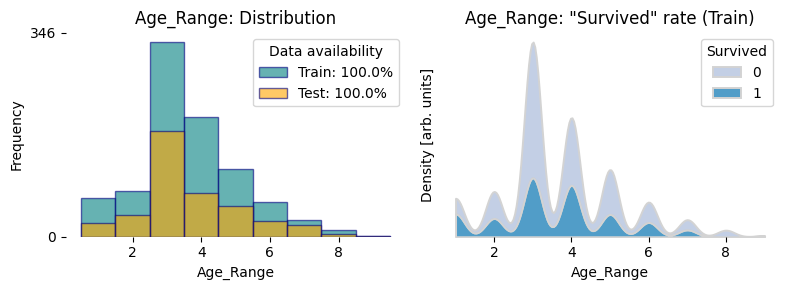

Explained Age_Range values and survival rates in training dataset:


Age_Range,Age,#Passengers,Survival_Rate[%]
1,"(-0.001, 9.0]",66,60.606061
2,"(9.0, 18.0]",77,41.558442
3,"(18.0, 27.0]",330,31.212121
4,"(27.0, 36.0]",203,44.334975
5,"(36.0, 45.0]",114,34.210526
6,"(45.0, 54.0]",59,42.372881
7,"(54.0, 63.0]",29,41.379310
8,"(63.0, 72.0]",11,0.000000
9,"(72.0, 81.0]",2,50.000000


In [28]:
# Plot distribution of values and survival rates:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure   
plot_dist_hist(train_df_corr,test_df_corr,'Age_Range',ax1,bin_step=1)
plot_surv_KDE(train_df_corr,'Age_Range',ax2)    
fig.tight_layout()
plt.show()

# Age_Range explained values:
AR_expl = pd.DataFrame(columns=['Age_Range','Age','#Passengers','Survival_Rate[%]'])
AR_expl['Age_Range'] = sorted(set(train_df_corr['Age_Range']))
AR_expl['Age'] = sorted(set(intervals))
AR_expl['#Passengers'] = [len(train_df_corr[train_df_corr['Age_Range'] == x])
                          for x in AR_expl['Age_Range']]
# Survival rates for each Age_Range category:
AR_expl['Survival_Rate[%]'] = [
    len(train_df_corr[(train_df_corr['Age_Range'] == x) & # Select age range
        (train_df_corr['Survived'] == 1)])/ # Passengers who survived
    len(train_df_corr[(train_df_corr['Age_Range'] == x)]) # Total passengers
    for x in AR_expl['Age_Range'] # Iterate through all age range values
]
AR_expl['Survival_Rate[%]'] *= 100 # Convert from fraction to [%]
print('Explained Age_Range values and survival rates in training dataset:')
AR_expl.style.hide()

<hr>

### <span style="color:teal;font-weight:bold;">Fare_Range</span> <span style="color:teal">new feature</span> <a class="anchor"  id="Fare_range_new_feature"></a>

I plan to do a <span style="font-weight:bold;">similar conversion from **Fare** to **Fare_Range**, grouping by fare ranges</span>, as previously done with **Age_Range**. However, the **Fare** distribution is qualitatively different compared to **Age**: values are mostly concentrated in the 0-50 interval, followed by a large tail up to $\approx$500. <span style="font-weight:bold;">Regular binning</span>, for example using intervals of width 20, is <span style="font-weight:bold;">probably a bad choice</span> because most of the bins will have few counts and poor statistics. Instead, <span style="font-weight:bold;">I choose to use logharitmic binning</span>, by first taking the logharithm of **Fare** (new range from 1 to 6.3) and then making regular bins of width equal to 1.

<span style="font-style:italic;">Note: For the logarithm operation, values must be strictly greater than 0. For this purpose, I consider all <span style="font-weight:bold;">Fare</span>=0 values as the minimum non-zero **Fare** value, equal to 3.17.</span>

In [29]:
# Find minimum fare above 0 and maximum fare:
fares = set(pd.concat([train_df_corr['Fare'], test_df_corr['Fare']])) # All fares
min_fare = sorted(fares)[1] # Minimum non-zero fare
max_fare = max(fares) # Manimum fare
# Create the new Fare_Range feature:
for dataset in [train_df_corr,test_df_corr]:
    # First copy the Fare future and fix all zero values:
    dataset['Fare_Range'] = dataset['Fare'] # Training dataset
    dataset.loc[dataset['Fare_Range']==0,'Fare_Range'] = min_fare
    # Convert to logarithmic scale:
    dataset['Fare_Range'] = np.log(dataset['Fare_Range'])
    # Make bins of width equal to 1 and encode:
    bins = np.arange(1,np.ceil(np.log(max_fare))+1,1)
    intervals = pd.cut(dataset['Fare_Range'], bins, include_lowest=False)
    dataset['Fare_Range'] = pd.factorize(intervals, sort=True)[0]+1

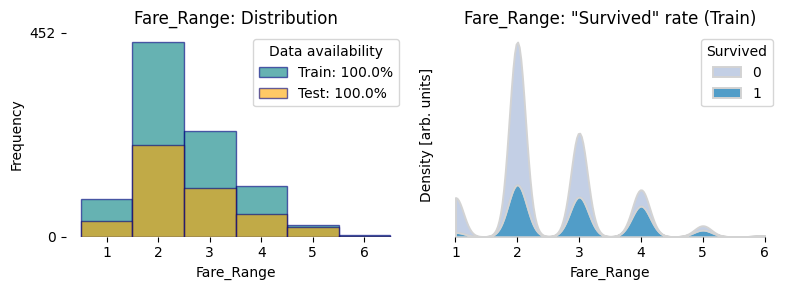

Explained Fare_Range values and survival rates in training dataset:


Fare_Range,Fare,#Passengers,Survival_Rate[%]
1,"(2.72, 7.39]",84,13.095238
2,"(7.39, 20.09]",431,30.626450
3,"(20.09, 54.6]",235,42.978723
4,"(54.6, 148.41]",112,69.642857
5,"(148.41, 403.43]",26,65.384615
6,"(403.43, 1096.63]",3,100.000000


In [30]:
# Plot distribution of values and survival rates:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) 
plot_dist_hist(train_df_corr,test_df_corr,'Fare_Range',ax1,bin_step=1)
plot_surv_KDE(train_df_corr,'Fare_Range',ax2)    
fig.tight_layout()
plt.show()

# Fare_Range explained values:
FR_expl = pd.DataFrame(columns=['Fare_Range','Fare','#Passengers','Survival_Rate[%]'])
FR_expl['Fare_Range'] = bins[:-1].astype(int)
FR_expl['Fare'] = [pd.Interval(np.round(np.e**bins[i],2), np.round(np.e**bins[i+1],2))
                   for i in range(len(bins)-1)]
FR_expl['#Passengers'] = [len(train_df_corr[train_df_corr['Fare_Range'] == x])
                          for x in FR_expl['Fare_Range']]
# Survival rates for each Fare_Range category:
FR_expl['Survival_Rate[%]'] = [
    len(train_df_corr[(train_df_corr['Fare_Range'] == x) & # Select fare range
        (train_df_corr['Survived'] == 1)])/ # Passengers who survived
    len(train_df_corr[(train_df_corr['Fare_Range'] == x)]) # Total passengers
    for x in FR_expl['Fare_Range'] # Iterate through all fare range values
]
FR_expl['Survival_Rate[%]'] *= 100 # Convert from fraction to [%]
print('Explained Fare_Range values and survival rates in training dataset:')
FR_expl.style.hide()

<hr>

### <span style="color:teal;font-weight:bold;">Family_size</span> <span style="color:teal">and</span> <span style="color:teal;font-weight:bold;">Family_Is_alone</span> <span style="color:teal">new features</span> <a class="anchor"  id="Family_size_and_family_is_alone_new_features"></a>

The <span style="font-weight:bold;">family members for each passenger</span> are indicated by the features **Parch** (parents and children) and **SibSp** (siblings and spouse). While these features provide valuable information, <span style="font-weight:bold;">the whole picture is missing</span>. <span style="font-weight:bold;">By simply summing these two features, the **Family_size** can be obtained</span>. This strategy has been adopted by many users (<a href="https://www.kaggle.com/code/startupsci/titanic-data-science-solutions">[MAN]</a>, <a href="https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy">[LD]</a>, <a href="https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling">[YAS]</a>, <a href="https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial">[GUN]</a>, <a href="https://www.kaggle.com/code/sakshamparashar/titanic-solution-eda-estimator-1">[SAK]</a>), also generating a <span style="font-weight:bold;">new feature **Family_Is_alone** that informs if the passenger is alone</span> (a special case of **Family_size**=1). In summary:

* **Family_size** is an integer-type feature, with a minimum value of 1 (self).

* **Family_Is_alone** is an integer-type feature resembling a boolean variable: 0 stands for "False", meaning the passenger is NOT alone, 1 stands for "True", meaning the passenger is alone.

In [31]:
for dataset in [train_df_corr,test_df_corr]:
    # Create 'Family_Size feature:
    dataset['Family_Size'] = dataset['SibSp']+dataset['Parch']+1
    # Create 'Is_alone' feature:
    dataset['Family_Is_alone'] = 1 # First initialized to 1 ("True")   
    dataset.loc[dataset['Family_Size']>1,'Family_Is_alone'] = 0 # Update all 0 ("False") values

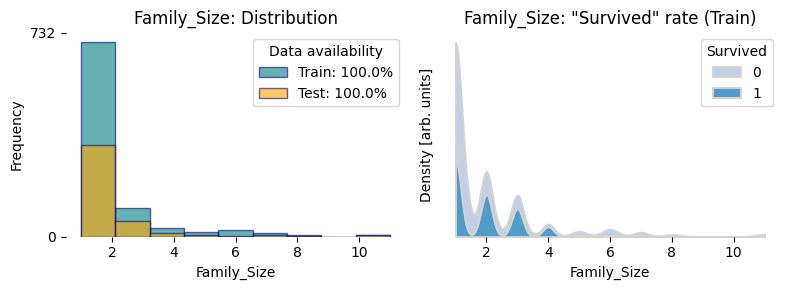

Explained Family_Size values and survival rates in training dataset:


Family_Size,#Passengers,Survival_Rate[%]
1,537,30.353818
2,161,55.279503
3,102,57.843137
4,29,72.413793
5,15,20.000000
6,22,13.636364
7,12,33.333333
8,6,0.000000
11,7,0.000000


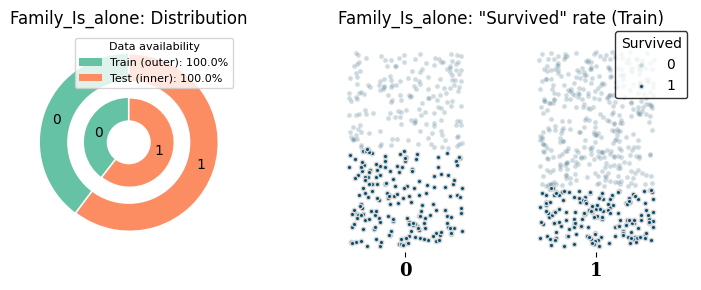

Explained Family_Is_alone values and survival rates in training dataset:


Family_Is_alone,#Passengers,Survival_Rate[%]
0,354,50.564972
1,537,30.353818


In [32]:
# Plot distribution of values and survival rates figures:
features = ['Family_Size', 'Family_Is_alone']
for feature in features:  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3)) # Start figure
    if feature == 'Family_Size':
        plot_dist_hist(train_df_corr,test_df_corr,feature,ax1)
        plot_surv_KDE(train_df_corr,feature,ax2)
    else:
        plot_dist_pie(train_df_corr,test_df_corr,feature,ax1)
        plot_surv_swarm(train_df_corr,feature,ax2)
    fig.tight_layout()
    plt.show()
    explain_stats(train_df_corr,feature)

From the **Family_Size** plots, the main message is that <span style="font-weight:bold;">big families ($>$4) are less likely to survive</span>. On the other hand, groups of 2, 3 or 4 have better chances (curiously groups of 4 have very high chances). This information is confirmed by the **Family_Is_alone** feature, showing <span style="font-weight:bold;">$\approx$30% survival rate for passengers traveling alone, and an average $\approx$50% for everyone else</span>.

<hr>

### <span style="color:teal">Renaming</span> <span style="color:teal;font-weight:bold;">Parch</span> <span style="color:teal">and</span> <span style="color:teal;font-weight:bold;">SibSp</span> <span style="color:teal">features</span> <a class="anchor"  id="Renaming_Parch_and_SibSp_features"></a>

Later, we will analyze correlations between features, and it will be helpful to <span style="font-weight:bold;">identify those features which are explicitely related by definition</span>. This is the case for **Family_Size** and **Family_Is_alone**, built from **Parch** and **SibSp**. Then, I rename **Parch** to **Family_Parch** and **SibSp** to **Family_SibSp**:

In [33]:
train_df_corr = train_df_corr.rename(columns={"Parch": "Family_Parch", "SibSp": "Family_SibSp"})
test_df_corr = test_df_corr.rename(columns={"Parch": "Family_Parch", "SibSp": "Family_SibSp"})

<hr>

### <span style="color:teal;font-weight:bold;">Ocurr_Ticket</span> <span style="color:teal">and</span> <span style="color:teal;font-weight:bold;">Prefix_Ticket</span> <span style="color:teal">new features</span> <a class="anchor"  id="Ocurr_ticket_and_prefix_ticket_new_features"></a>

At first glance, the **Ticket** feature doesn't seem very informative, because there are <span style="font-weight:bold;">too many unique values and often mysterious prefixes</span>, such as "A/5 21171". However, there are a few details that stand out and might be useful:

* <span style="font-weight:bold;">Most of the tickets are unique</span>, but some of them have multiple ocurrences in the combined datasets.
  
* Almost all **Ticket** values have a number, but <span style="font-weight:bold;">only some have a prefix</span>.

First, I build the <span style="font-weight:bold;">new feature **Ocurr_Ticket**: the number of times a ticket appears</span> in the combined tranining and testing dataset.

In [34]:
# Identify ocurrences for every unique value in **Ticket** for the combined datasets:
all_tickets = pd.concat([train_df_corr['Ticket'], test_df_corr['Ticket']]).value_counts().to_dict()
for dataset in [train_df_corr,test_df_corr]:
    dataset['Ocurr_Ticket'] = dataset['Ticket'].apply(lambda x: all_tickets[x])

The values for **Ocurr_Ticket** are similar to **Family_Size**... <span style="font-weight:bold;">are they related?</span> Do all family members share the same ticket? Let's have a look:

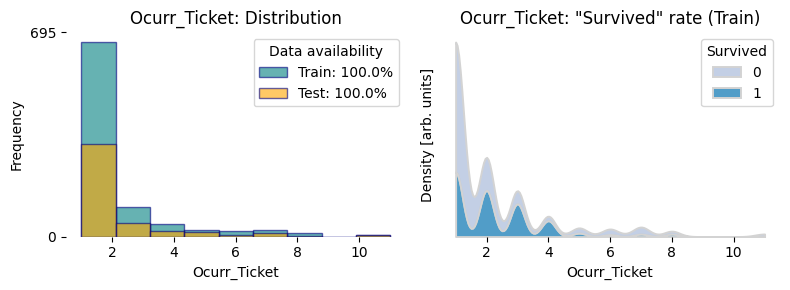

Explained Ocurr_Ticket values and survival rates in training dataset:


Ocurr_Ticket,#Passengers,Survival_Rate[%]
1,481,27.027027
2,181,51.381215
3,101,65.346535
4,44,72.727273
5,21,33.333333
6,19,21.052632
7,24,20.833333
8,13,38.461538
11,7,0.000000


In [35]:
# Plot distribution of values and survival rates:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3)) # Start figure
plot_dist_hist(train_df_corr,test_df_corr,'Ocurr_Ticket',ax1)
plot_surv_KDE(train_df_corr,'Ocurr_Ticket',ax2)
fig.tight_layout()
plt.show()
explain_stats(train_df_corr,'Ocurr_Ticket')

In [36]:
train_df_corr[train_df_corr['Ocurr_Ticket']>7][
['Name','Ticket','Cabin','Ocurr_Ticket','Family_Size','Survived']].sort_values(by='Ticket')

,Name,Ticket,Cabin,Ocurr_Ticket,Family_Size,Survived
838,"Chip, Mr. Chang",1601,X,8,1,1
74,"Bing, Mr. Lee",1601,X,8,1,1
826,"Lam, Mr. Len",1601,X,8,1,0
169,"Ling, Mr. Lee",1601,X,8,1,0
692,"Lam, Mr. Ali",1601,X,8,1,1
643,"Foo, Mr. Choong",1601,X,8,1,1
509,"Lang, Mr. Fang",1601,X,8,1,1
59,"Goodwin, Master. William Frederick",CA 2144,X,8,8,0
683,"Goodwin, Mr. Charles Edward",CA 2144,X,8,8,0
678,"Goodwin, Mrs. Frederick (Augusta Tyler)",CA 2144,X,8,8,0


It's clear that tickets 'CA 2144' and 'CA 2343' belong to the Goodwin and Sage families, respectively (with the missing family members likely in the testing dataset). However, the ticket '1601' is shared by individual passengers, perhaps with a common Asian background. <span style="font-weight:bold;">It seems reasonable to think that passengers holding the same ticket are allocated in the same room</span>.

That's all for the **Ocurr_Ticket** feature. Next, I <span style="font-weight:bold;">identify the ticket prefixes</span> and build the **Prefix_Ticket** feature.

*Note: tickets without a prefix are registered as 'None'.*

In [37]:
# Concatenate all ticket values:
all_tickets = pd.concat([train_df_corr['Ticket'], test_df_corr['Ticket']]).value_counts().to_dict()
ticket_aux = [ticket.split() for ticket in all_tickets] # Separate prefix and number
prefixes = [ticket[0] if not ticket[0].isnumeric() else 'None' for ticket in ticket_aux] # Identify the ticket prefix
# Generate **Prefix_Ticket** and **Ocurr_Ticket**:
print('Unique values for Prefix_Ticket:')
" ; ".join(sorted(set(prefixes)))

Unique values for Prefix_Ticket:


'A. ; A./5. ; A.5. ; A/4 ; A/4. ; A/5 ; A/5. ; A/S ; A4. ; AQ/3. ; AQ/4 ; C ; C.A. ; C.A./SOTON ; CA ; CA. ; F.C. ; F.C.C. ; Fa ; LINE ; LP ; None ; P/PP ; PC ; PP ; S.C./A.4. ; S.C./PARIS ; S.O./P.P. ; S.O.C. ; S.O.P. ; S.P. ; S.W./PP ; SC ; SC/A.3 ; SC/A4 ; SC/AH ; SC/PARIS ; SC/Paris ; SCO/W ; SO/C ; SOTON/O.Q. ; SOTON/O2 ; SOTON/OQ ; STON/O ; STON/O2. ; STON/OQ. ; SW/PP ; W./C. ; W.E.P. ; W/C ; WE/P'

<span style="font-weight:bold;">What do these prefixes mean?</span> I've done some research but couldn't find much... 'PC' may stand for 'Private Cabin', 'STON' might mean 'Southampton' and 'LINE' could reference the company 'American Line', which operated the Titanic. On the other hand, <span style="font-weight:bold;">it seems that many prefixes have different nomenclatures but most probably indicate the same information</span>, for example ['A./5.', 'A/5.' and 'A/5'] or [W./C. and W/C]. <span style="font-weight:bold;">I simplify Prefix_Ticket using the following rules</span>:

* All dots '.' are eliminated.

* Tickets starting with 'A', 'C', 'F', 'P', 'SC', 'SP', 'SW' and 'W' are simplified to that same initials (e.g. 'A/5' --> 'A' ; 'S.W./PP' --> 'SW').

* Tickets including 'SOTON' or 'STON' in their names are labeled as 'SOTON' or 'STON', respectively. Any remaining tickets that start with 'SO' are labeled as 'SO'.

In [38]:
for dataset in [train_df_corr,test_df_corr]:
    # Generate new **Ticket_Prefix** feature:
    ticket_aux = [ticket.split() for ticket in dataset['Ticket']] # Separate prefix and number
    prefixes = [ticket[0] if not ticket[0].isnumeric() else 'None' 
                for ticket in ticket_aux] # Identify the ticket prefix
    # Generate new feature:
    dataset['Prefix_Ticket'] = prefixes
    # Eliminate all dots:
    dataset['Prefix_Ticket'] = dataset['Prefix_Ticket'].apply(lambda x: x.replace('.',''))
    # Change short initials except 'SO' (add dummy letter to avoid problems with single-letter values):
    for initial in ['A', 'C', 'F', 'P', 'SC', 'SP', 'SW', 'W']:
        dataset['Prefix_Ticket'] = dataset['Prefix_Ticket'].apply(
            lambda x: initial if (x+'X')[:len(initial)]==initial else x)
    # Assign 'SO' values to those prefixes starting with 'SO' except for 'SOTON' tickets:
    dataset['Prefix_Ticket'] = dataset['Prefix_Ticket'].apply(
        lambda x: 'SO' if (x+'X')[:2]=='SO' and 'SOTON' not in x else x)
    # Change long initials:
    for initial in ['STON', 'SOTON']:
        dataset['Prefix_Ticket'] = dataset['Prefix_Ticket'].apply(
            lambda x: initial if initial in x else x) 

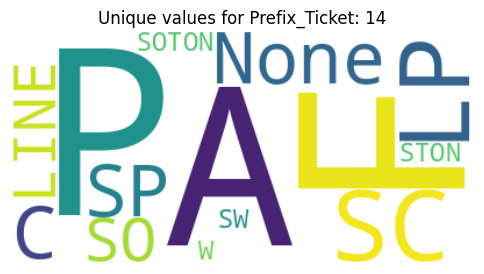

Explained Prefix_Ticket values and survival rates in training dataset:


Prefix_Ticket,#Passengers,Survival_Rate[%]
A,29,6.896552
C,47,34.042553
F,7,57.142857
LINE,4,25.000000
None,661,38.426626
P,65,64.615385
SC,17,47.058824
SO,10,10.000000
SOTON,17,11.764706
SP,1,0.000000


In [39]:
# Plot wordcloud:
prefix_set = set(list(train_df_corr['Prefix_Ticket'].values)+list(test_df_corr['Prefix_Ticket'].values))
prefixes = " ".join(prefix_set).replace('.','x').replace('/','_') # Convert to adequate format
wordcloud = WordCloud(stopwords=[],background_color="white",random_state=0).generate(prefixes)
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Unique values for Prefix_Ticket: {len(prefix_set)}")
plt.axis("off")
plt.show()
explain_stats(train_df_corr,'Prefix_Ticket',unique_vals_max=20)   

<span style="font-weight:bold;">The simplified feature **Prefix_Ticket** is now much easier to analyze</span>. Looking at the table, we can check that some values, such as 'SP' and 'SW', have very low counts and are unlikely to be useful for a ML model. In addition, the 'LP' label only appears in the testing dataset.

To address all these issues, I choose to <span style="font-weight:bold;">convert to 'None' all those features with fewer counts than 10</span>: 'SC', 'SP', 'SW', 'LP', 'LINE'.

In [40]:
initials = ['SC', 'SP', 'SW', 'LP', 'LINE'] # Initials to be converted to 'None'
for dataset in [train_df_corr,test_df_corr]:
    dataset['Prefix_Ticket'] = dataset['Prefix_Ticket'].apply(
        lambda x: 'None' if x in initials else x)

<hr>

### <span style="color:teal;font-weight:bold;">Pcl_Age_Sex_surv</span> <span style="color:teal">new feature</span> <a class="anchor"  id="Pcl_age_sex_surv_new_feature"></a>

<span style="font-weight:bold;">This new feature is strongly driven but my initial guesses</span>, in which I propose that **Women and children** and **Wealth** are indicators that play a central role for the survival probabilities. The **Pcl_Age_Sex_surv** feature combines these attributes using **Pclass**, **Age** and **Sex** features, and <span style="font-weight:bold;">assigns a value based on the <font color=green>average survival probability in the corrected training dataset</font></span>. As a <font color=blue>reference</font>, I include the survival rates for these subgroups according to the reported values in <a href="https://en.wikipedia.org/wiki/Sinking_of_the_Titanic">Wikipedia</a>.

In [41]:
# Define conditions for the subgroups in the training dataset:
cond_children = (train_df_corr['Age']<18)
cond_women = (train_df_corr['Sex']=='female') & ~cond_children
cond_men = (train_df_corr['Sex']=='male') & ~cond_children
conds_train = {'Children (Age<18)':cond_children, 
               'Women (Age>18, Sex=female)':cond_women, 
               'Men (Age>18, Sex=male)':cond_men} # Group conditions
# Create a dictionary with Pclass as keys, reference rates [%] as values:
# [https://en.wikipedia.org/wiki/Sinking_of_the_Titanic]
refs = {'Children (Age<18)': {1:83, 2:100, 3:34},
        'Women (Age>18, Sex=female)': {1:97, 2:86, 3:54},
        'Men (Age>18, Sex=male)': {1:33, 2:8, 3:16}
       }
# Calculate survival rates from training dataset dataset and compare them with reference:
from termcolor import colored

rates = {} # Initiate dictionary to store Pcl_Age_Sex_surv rates
for label in conds_train:
    print(f'\n{label} survival rates:')
    for pclass in [1,2,3]:
        cond = conds_train[label] & (train_df_corr['Pclass']==pclass)
        rate = sum(train_df_corr[cond]['Survived'])/len(train_df_corr[cond]) # Survival rate
        rates[(label,pclass)] = np.round(rate,2) # Round to 2 digits
        print(f'Pclass {pclass}:',colored(f'{int(rate*100)}% training','green'),\
             colored(f'(reference {refs[label][pclass]}%)','blue'))


Children (Age<18) survival rates:
Pclass 1: 91% training (reference 83%)
Pclass 2: 91% training (reference 100%)
Pclass 3: 37% training (reference 34%)

Women (Age>18, Sex=female) survival rates:
Pclass 1: 97% training (reference 97%)
Pclass 2: 90% training (reference 86%)
Pclass 3: 48% training (reference 54%)

Men (Age>18, Sex=male) survival rates:
Pclass 1: 34% training (reference 33%)
Pclass 2: 8% training (reference 8%)
Pclass 3: 11% training (reference 16%)


Survival rates obtained from the corrected training dataset (<font color=green>green</font>) are very close to the reference values (<font color=blue>blue</font>). This is not a proof that the new feature is "correct", it is just a framework that proves that it "makes sense".

The following lines generate the new feature and include it in the datasets. <span style="font-weight:bold;">Each passenger is assigned a fixed **Pcl_Age_Sex_surv** value according to the subgroup (defined above) they belong</span>.

In [42]:
for dataset in [train_df_corr,test_df_corr]:
    # Determine conditions for subgroups:
    cond_children = (dataset['Age']<18)
    cond_women = (dataset['Sex']=='female') & ~cond_children
    cond_men = (dataset['Sex']=='male') & ~cond_children
    conds = {'Children (Age<18)':cond_children,
             'Women (Age>18, Sex=female)':cond_women,
             'Men (Age>18, Sex=male)':cond_men} # Group conditions   
    # Create feature, based on subgroups:
    dataset['Pcl_Age_Sex_surv'] = 0. # first initialized to 0. (float)
    for label in conds:
        for pclass in [1,2,3]:
            # Training:
            cond = conds[label] & (dataset['Pclass']==pclass)
            dataset.loc[cond,'Pcl_Age_Sex_surv'] = rates[(label,pclass)]
            # Testing:
            cond_test = conds[label] & (dataset['Pclass']==pclass)
            test_df_corr.loc[cond,'Pcl_Age_Sex_surv'] = rates[(label,pclass)]

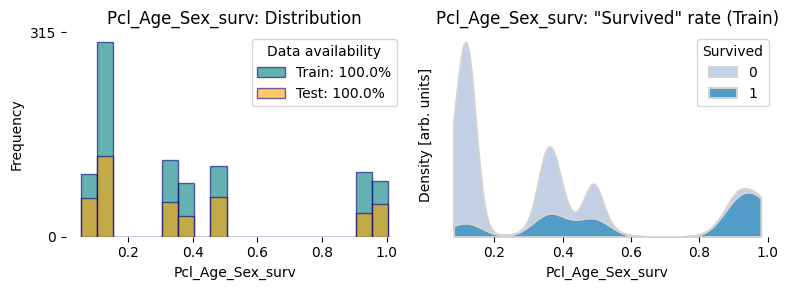

Explained Pcl_Age_Sex_surv values and survival rates in training dataset:


Pcl_Age_Sex_surv,#Passengers,Survival_Rate[%]
0.080000,97,8.247423
0.120000,300,11.666667
0.350000,118,34.745763
0.380000,82,37.804878
0.490000,109,48.623853
0.910000,87,90.804598
0.920000,12,91.666667
0.980000,86,97.674419


In [43]:
# Plot distribution of values and survival rates:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3)) # Start figure
plot_dist_hist(train_df_corr,test_df_corr,'Pcl_Age_Sex_surv',ax1,bin_step=0.05)
plot_surv_KDE(train_df_corr,'Pcl_Age_Sex_surv',ax2)
fig.tight_layout()
plt.show()
explain_stats(train_df_corr,'Pcl_Age_Sex_surv')

<hr>

## <font color='teal'>Feature encoding (turn numeric)</font> <a class="anchor"  id="Feature_encoding"></a>

The final step of the feature engineering process is to <span style="font-weight:bold;">ensure that all features are either numeric or boolean</span>, so any ML model can be trained straightforward on them. This means that string-type features such as **Sex** or **Cabin** must be encoded.

The method that I choose is <span style="font-weight:bold;">OneHot-encoding, where each object-type feature is converted into multiple binary features</span> corresponding to its unique values. For instance, **Embarked** has three unique values "C", "Q" and "S", then it is converted in **Embarked_C**, **Embarked_Q** and **Embarked_S** features. Consequently, a passenger that embarked in "Q" will have **Embarked_C**=0, **Embarked_Q**=1 and **Embarked_S**=0. In the following lines, I create new encoded datasets.

*Note 1: I drop the **Name** and **Ticket** features, since they were already used to correct and create other features, extracting the valuable information. Keeping them is not worth it because they have too many unique values for OneHot-encoding.*

*Note 2: for the **Sex** binary feature, keeping only one of the two OneHot-encoded **Sex_female** or **Sex_male** features is enough, since they are directly correlated. I choose to drop **Sex_male**.*

In [44]:
# Select features to be encoded:
feat_enc = ['Sex', 'Embarked', 'Cabin', 'Title', 'Prefix_Ticket']
# Encode features:
data_train_enc = pd.get_dummies(train_df_corr[feat_enc]) # Training dataset
data_test_enc = pd.get_dummies(test_df_corr[feat_enc]) # Testing dataset
# Prepare dataframes having only numeric/boolean features:
train_df_enc = pd.concat([train_df_corr, data_train_enc], axis=1)
test_df_enc = pd.concat([test_df_corr, data_test_enc], axis=1)
# Sort columns alphabetically, but leave 'Survived' at the beggining in training dataset:
train_df_enc = train_df_enc.reindex(sorted(train_df_enc.columns), axis=1)
train_df_enc = train_df_enc[['Survived'] + [col for col in train_df_enc.columns 
                                            if col != 'Survived' ]]
test_df_enc = test_df_enc.reindex(sorted(test_df_enc.columns), axis=1)
# Drop unnecesary features: 
train_df_enc = train_df_enc.drop(feat_enc+['Name','Ticket','Sex_male'],axis=1)
test_df_enc = test_df_enc.drop(feat_enc+['Name','Ticket','Sex_male'],axis=1)

print('_'*40+'\n\nTRAINING DATASET:\n')
train_df_enc.info()

________________________________________

TRAINING DATASET:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    int64  
 1   Age                  891 non-null    float64
 2   Age_Range            891 non-null    int64  
 3   Cabin_A              891 non-null    bool   
 4   Cabin_B              891 non-null    bool   
 5   Cabin_C              891 non-null    bool   
 6   Cabin_D              891 non-null    bool   
 7   Cabin_E              891 non-null    bool   
 8   Cabin_H              891 non-null    bool   
 9   Cabin_X              891 non-null    bool   
 10  Embarked_C           891 non-null    bool   
 11  Embarked_Q           891 non-null    bool   
 12  Embarked_S           891 non-null    bool   
 13  Family_Is_alone      891 non-null    int64  
 14  Family_Parch         891 non-

<hr>

### <font color='teal'>Checkpoint 2</font> <a class="anchor"  id="Checkpoint_2"></a>

Featuring engineering is complete! <span style="font-weight:bold;">The original datasets have grown from 10 features to 36 OneHot-encoded features</span>, with all missing values corrected. As the final step of the Data Analysis section, I analyze the features' correlations and extract information that will be used for training Machine Learning models.

<hr>

## <font color='teal'>Feature correlations</font> <a class="anchor"  id="Feature_correlations"></a>

<span style="font-weight:bold;">How closely related is each feature to **Survived**? What's the mutual relationship between any two features?</span> These are the questions that we are going to answer with a <span style="font-weight:bold;">correlation matrix</span>.

A short explanation: for <span style="font-weight:bold;">any two features **feat_A** and **feat_B**, a correlation value $c$ between -1 and 1 can be assigned</span>. Any <span style="font-weight:bold;">positive correlation</span> ($c>0$) means that there is a general tendency for <span style="font-weight:bold;">high values of **feat_A**</span> to occur simultaneously with <span style="font-weight:bold;">high values of **feat_B**</span> (remember that all our features are numeric or boolean now). The higher the $c$ value the more consistent is the correlation across the entire dataset. Conversly, a <span style="font-weight:bold;">negative correlation</span> ($c<0$) implies that <span style="font-weight:bold;">high values in **feat_A**</span> are associated with <span style="font-weight:bold;">low values in **feat_B**</span>. Lastly, <span style="font-weight:bold;">$c=0$ indicates no general rule</span>, and the correspondence between **feat_A** and **feat_B** is quite random.

To give some examples, we <span style="font-weight:bold;">can expect a negative correlation between **Pclass** and **Fare**</span>, as the more expensive tickets are generally associated with higher passenger classes (remember that first class has the lowest **Pclass**=1 value). On the other hand, <span style="font-weight:bold;">**Sex_female** and **Title_Miss** should have a positive correlation</span>, though not $c=1$ because not all females have the 'Miss' title.

The <span style="font-weight:bold;">correlation matrix</span> is displayed as a <span style="font-weight:bold;">double-entry table</span>, with all features listed in both axes. <span style="font-weight:bold;">Each intersection represents the correlation between the two crossing features, and it is color-coded according to the $c$ value</span>. Since any mutual relationship would appear twice in the plot, I only plot the lower triangle of the matrix, avoiding repetitions. Lastly, <span style="font-weight:bold;">features that share the same root name</span>, such as **Family_Parch** and **Family_Size**, have obvious correlations because some of them were built on top of the others by definition. Those groups are identified by <span style="font-weight:bold;">dotted triangles</span>.

Because there are 36 features, the full correlation matrix is very dense and can be confusing... but only some correlations are actually meaningful (either positive or negative large values). <span style="font-weight:bold;">A way to highlight the important information is to set a threshold correlation value $c_{thres}$ and only paint those feature crossings with $|c|>c_{thres}$</span>. You can tune this parameter in the code (set it to 0 if you prefer to see all correlations), <span style="font-weight:bold;">I've chosen $c_{thres}=0.1$</span>.

Next, I plot the <span style="font-weight:bold;">correlation matrix for the training dataset</span>, for which the **Survived** correlations are separated in the first column:

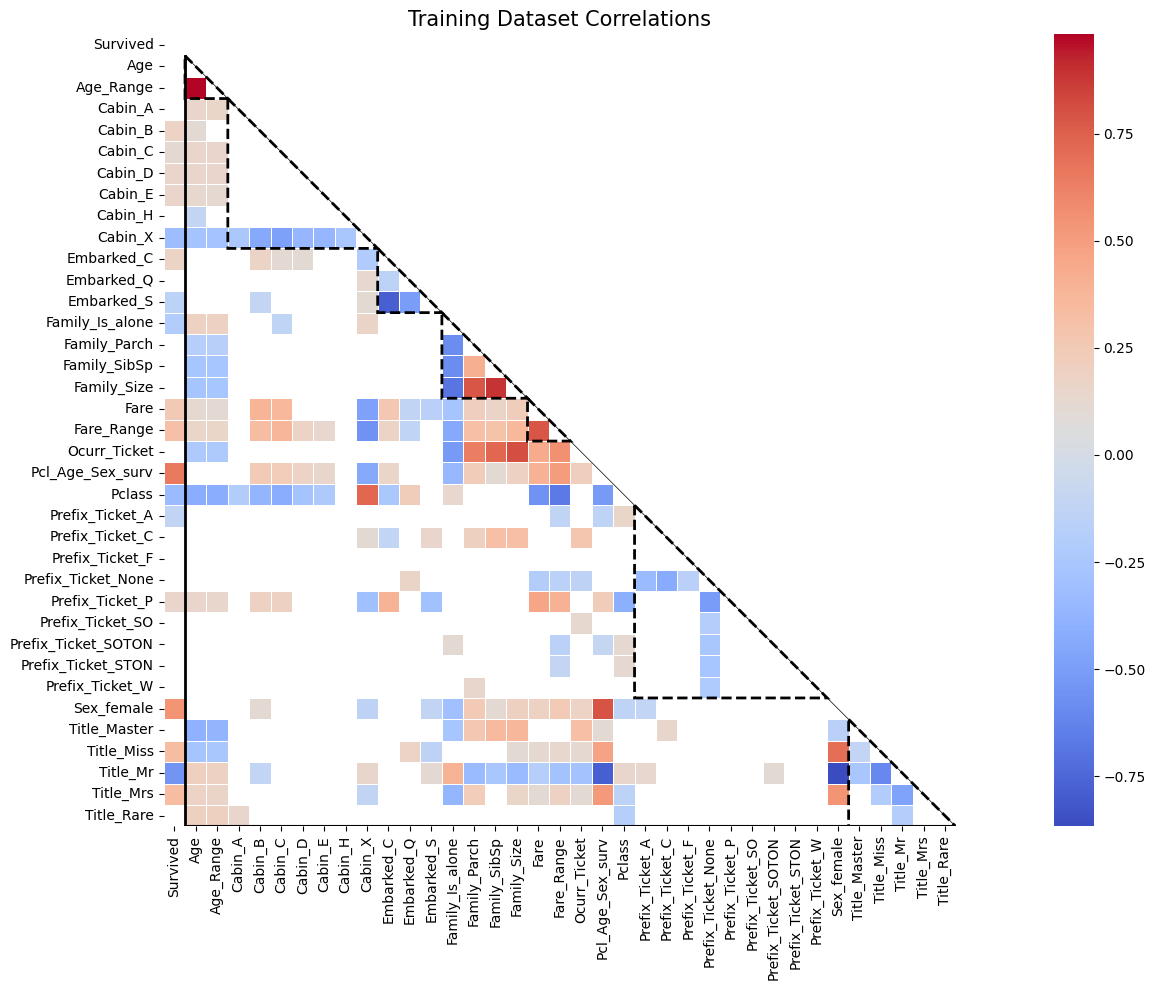

In [45]:
import matplotlib.patches as patches

# Prepare data:
corr_train = train_df_enc.corr() # Obtain correlations
trimask = np.triu(np.ones_like(corr_train, dtype=bool)) # Mask upper triangle in correlations
c_thres = 0.1 # Threshold value to show correlations

fig, ax = plt.subplots(figsize=(20, 10))
# Plot correlations in training dataset:
sns.heatmap(corr_train, ax=ax, square=True, cmap='coolwarm',
            linecolor='w',lw=0.5, mask=trimask | (np.abs(corr_train) <= c_thres))
# Separate the "Survived" correlations:
ax.plot([1,1],[1,len(train_df_enc.columns)],color='k',lw=2)
# Draw the correlations' triangle:
ax.plot([1,len(train_df_enc.columns)],[1,len(train_df_enc.columns)],color='k',lw=0.5)
ax.plot([1,len(train_df_enc.columns)],[len(train_df_enc.columns),len(train_df_enc.columns)],
        color='k',lw=1.5)
# Identify blocks of similar features:
main_name = [feat.split('_')[0] for feat in list(train_df_enc.columns)]
index_counts = [(main_name.index(name),main_name.count(name))
                for name in sorted(set(main_name))]
for index, counts in index_counts:
    if counts>1: 
        triangle = [[index, index],
                    [index+counts, index+counts],
                    [index, index+counts]]
        ax.add_patch(patches.Polygon(triangle, edgecolor="k",facecolor='none',ls="--",lw=2))
ax.set_title(f"Training Dataset Correlations", size=15)
fig.tight_layout()
plt.show()

In this matrix, there's <span style="font-weight:bold;">plenty of information that can be used for further feature engineering</span> and selecting a subset of features to train a ML model. This time, I just choose a <span style="font-weight:bold;">subset of features whose absolute **Survived**-correlations are larger than 0.1</span>.

In [46]:
feats_high_corr = train_df_enc.columns[abs(corr_train['Survived'])>0.1].delete(0) # ('Survived' is deleted)

Another aspect that we can examine using correlations is <span style="font-weight:bold;">how different the training and testing datasets are</span>. This can be <span style="font-weight:bold;">critical for the ML models</span>, as any strong or weak correlations that appear only in one dataset may put the model out of balance.

The following lines independently calculate the correlations for both datasets and then substract them, building the <span style="font-weight:bold;">'difference' correlation matrix</span>. For any two features, <span style="font-weight:bold;">if the correlations are similar in both datasets, then the difference will be close to 0</span>. I follow the same threshold criterion as before for easier visualization, then <span style="font-weight:bold;">only paint values whose absolute value is larger than 0.1</span>.

*Note: the **Survived** column in the training dataset is ignored.*

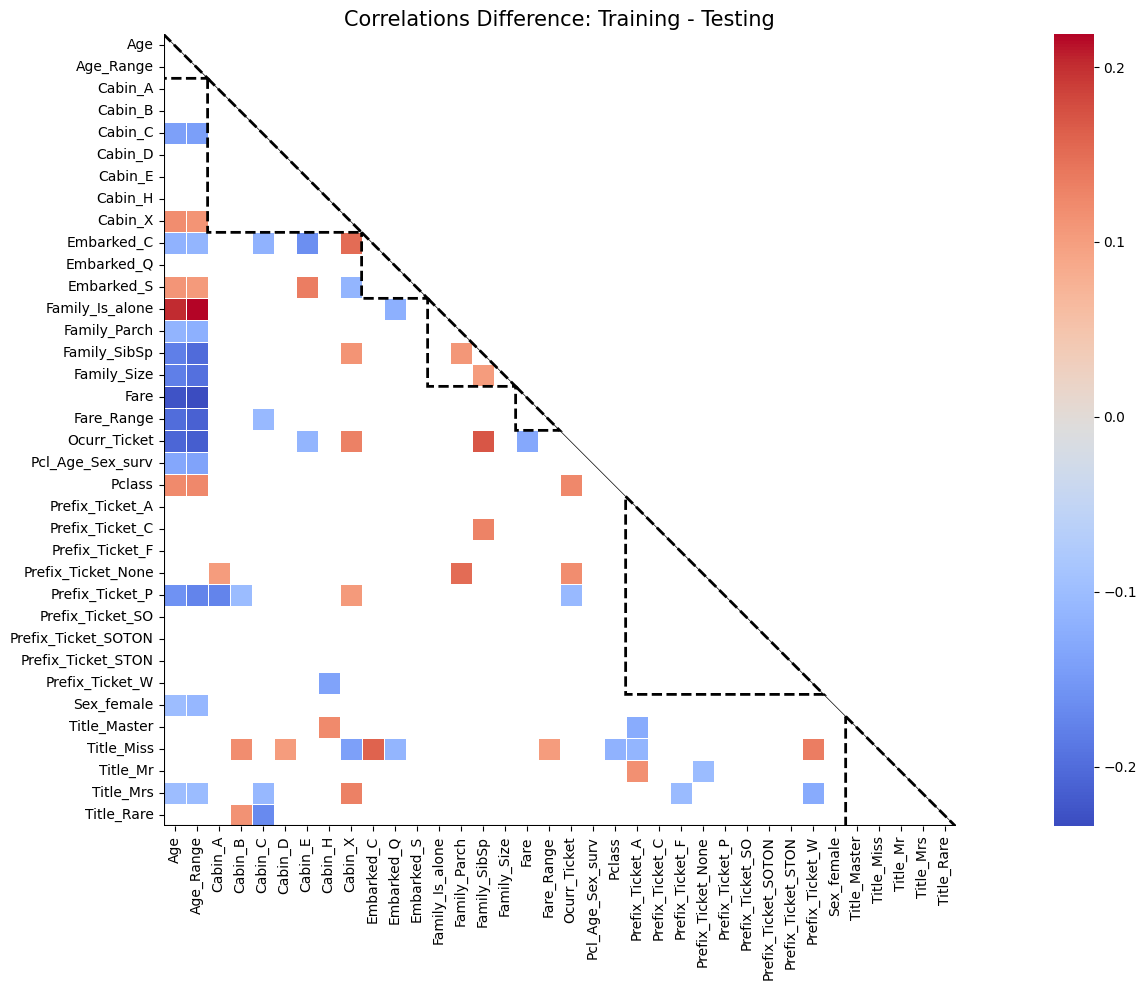

In [47]:
import matplotlib.patches as patches

# Prepare data:
corr_diff = train_df_enc.drop(['Survived'],axis=1).corr()-test_df_enc.corr() # Correlations difference
trimask = np.triu(np.ones_like(corr_diff, dtype=bool)) # Mask upper triangle in correlations
thres_diff = 0.1 # Threshold value to show correlations

fig, ax = plt.subplots(figsize=(20, 10))
# Difference in correlations (training - testing):
sns.heatmap(corr_diff, ax=ax, square=True, cmap='coolwarm',
            linecolor='w',lw=0.5, mask=trimask | (np.abs(corr_diff) <= thres_diff))
# Draw the correlations' triangle:
ax.plot([0,len(test_df_enc.columns)],[0,len(test_df_enc.columns)],color='k',lw=0.5)
ax.plot([0,len(test_df_enc.columns)],[len(test_df_enc.columns),len(test_df_enc.columns)],
        color='k',lw=1.5)
ax.plot([0,0],[0,len(test_df_enc.columns)],color='k',lw=1.5)
# Identify blocks of similar features:
main_name = [feat.split('_')[0] for feat in list(test_df_enc.columns)]
index_counts = [(main_name.index(name),main_name.count(name))
                for name in sorted(set(main_name))]
for index, counts in index_counts:
    if counts>1: 
        triangle = [[index, index],
                    [index+counts, index+counts],
                    [index, index+counts]]
        ax.add_patch(patches.Polygon(triangle, edgecolor="k",facecolor='none',ls="--",lw=2))
ax.set_title(f"Correlations Difference: Training - Testing", size=15)
fig.tight_layout()
plt.show()

Good news: most of the correlations are similar in both datasets. However, <span style="font-weight:bold;">Age and Age_Range should be carefully considered when building ML models</span>, as their behavior fluctuates between the training and testing datasets.

<hr>

# <font color='teal'>Section III: Machine learning models</font> <a class="anchor"  id="Section_III"></a>

Time to build the ML models! In this Section, I define many <span style="font-weight:bold;">ML models with different complexities:</span> individual <span style="color:green;font-weight:bold;">Basic</span> algorithms such as a Random Forest Estimator; <span style="color:blue;font-weight:bold;">Ensemble</span> models that collect the independient predictions of basic models and then make a final a decision via majority vote; and <span style="color:red;font-weight:bold;">Stacking</span> structures where basic models are concatenated in two layers, with the outputs from the first layer serving as the inputs for the second layer. Despite their differences, <span style="font-weight:bold;">all these models share the following characteristics</span>:

* They are <span style="font-weight:bold;">Supervised</span>, meaning they are trained by comparing the (<span style="font-weight:bold;">Survived</span>) predictions with <span style="font-weight:bold;">ground truth labels</span>.

* They have <span style="font-weight:bold;">Shallow Learning architectures</span>, since the training dataset is small (less than 900 rows).

* As all features are encoded, all ML models are <span style="font-weight:bold;">compatible with any subset of features</span>.

In this stage, I focus on obtaining <span style="font-weight:bold;">general results for each model using different subsets of features</span> (optimization will be the topic of the next stage, only for a few selected models). I use two <span style="font-weight:bold;">evaluation metrics</span>: 

* <span style="font-style:italic;text-decoration:underline">Training score</span>: average score of 5-fold <span style="font-weight:bold;">cross-validation</span>, using only the <span style="font-weight:bold;">training dataset</span>.

* <span style="font-style:italic;text-decoration:underline">Submission score</span>: average score of 5 <span style="font-weight:bold;">submissions</span> to the Kaggle competition, using the <span style="font-weight:bold;">testing dataset</span> after training the model on the training dataset, each time with a different seed for the random initial state.

The following table describes all the ML models that I analyze in this stage:

| Designation | Description | Libraries |
| :---: | :---: | :---: |
| <span style="color:green;font-weight:bold;">Basic</span> | Individual models | RandomForestClassifier, LogisticRegression, GradientBoostingClassifier, HistGradientBoostingClassifier, XGBClassifier, KNeighborsClassifier, LinearSVC |
| <span style="color:blue;font-weight:bold;">Ensemble</span> | Horizontal collection of basic models, final output via majority vote | VotingClassifier |
| <span style="color:red;font-weight:bold;">Stacking</span> | Hierarchical collection of basic models, outputs are concatenated | StackingClassifier |

Remember that <span style="font-weight:bold;">I'm not optimizing the models yet</span>, just getting a rough idea of how accurate they can be. Therefore, I choose <span style="font-weight:bold;">default parameters</span> for the <span style="color:green;font-weight:bold;">Basic</span> models and just make a few variations for the others:

* <span style="color:blue;font-weight:bold;">Ensemble</span> models are built with either <span style="font-weight:bold;">1, 3 or 6 instances</span> of each <span style="color:green;font-weight:bold;">Basic</span> model.
  
* <span style="color:red;font-weight:bold;">Stacking</span> models are built with <span style="font-weight:bold;">1 instance of each</span> <span style="color:green;font-weight:bold;">Basic</span> model for the <span style="font-weight:bold;">first layer</span>, and a <span style="font-weight:bold;">single</span> <span style="color:green;font-weight:bold;">Basic</span> model as the <span style="font-weight:bold;">final estimator</span> (second layer).

In [52]:
# Load the solution, used to evaluate the model:
y_train = train_df_enc['Survived'] # General labels for all training sets
y_sol = pd.read_csv('titanic-fm/solutions.csv')['Survived'] # Solution (testing) dataset
seed = 0 # Set seed for reproducibility

# Define models:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
HistGradientBoostingClassifier, VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import copy

# Define Basic models:
b_models = {"B_RF": RandomForestClassifier(random_state=seed),
            "B_LR": LogisticRegression(random_state=seed),
            "B_GB": GradientBoostingClassifier(random_state=seed),
            "B_HGB": HistGradientBoostingClassifier(random_state=seed),
            "B_XGB": XGBClassifier(random_state=seed),
            "B_KN": KNeighborsClassifier(),
            "B_SVC": LinearSVC(random_state=seed,dual=False)
           }
b_all = [(model,b_models[model]) for model in b_models] # Group all basic models for Ensemble and Stacking

# Define Ensemble models:
e_models = {}
for N in [1,3,6]:
    # Create N instances of the same basic model, but with different initialization seeds:
    many_b_models = {}
    for model in b_models:
        for i in range(N):
            many_b_models[f"{model}_{i}"] = copy.deepcopy(b_models[model]) # Replicate Basic model
            many_b_models[f"{model}_{i}"].random_state = i # Change seed
    # Build Ensemble model:
    e_models[f"E_{N}"] = VotingClassifier(estimators=[(model,many_b_models[model]) for model in many_b_models])

# Define Stacking models:
s_models = {}
for model in b_models:
    s_models[f"S_{model[2:]}"] = StackingClassifier(
    estimators=b_all, final_estimator=b_models[model])
# Combine all models in a single dictionary:
all_models = {**b_models, **e_models, **s_models}

# Visualize examples: colored(f'{int(rate*100)}% training','green')
print('Example of an', colored('Ensemble','blue',attrs=['bold']) ,'model with only 1 instance of each Basic model:')
display(e_models['E_1'])
print('\nExample of a', colored('Stacking','red',attrs=['bold']) ,'model with a XGBClassifier Basic model as the final estimator:')
display(s_models['S_XGB'])

Example of an Ensemble model with only 1 instance of each Basic model:


VotingClassifier(estimators=[('B_RF_0', RandomForestClassifier(random_state=0)),
                             ('B_LR_0', LogisticRegression(random_state=0)),
                             ('B_GB_0',
                              GradientBoostingClassifier(random_state=0)),
                             ('B_HGB_0',
                              HistGradientBoostingClassifier(random_state=0)),
                             ('B_XGB_0',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=Non...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=0, ...)),
                             ('B_KN_0', KNeighborsClassifier()),
                             ('B_SVC_0',
                              LinearSVC(dual=False, random_state=0))])


Example of a Stacking model with a XGBClassifier Basic model as the final estimator:


StackingClassifier(estimators=[('B_RF', RandomForestClassifier(random_state=0)),
                               ('B_LR', LogisticRegression(random_state=0)),
                               ('B_GB',
                                GradientBoostingClassifier(random_state=0)),
                               ('B_HGB',
                                HistGradientBoostingClassifier(random_state=0)),
                               ('B_XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsam...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=0, ...))

<hr>

## <font color='teal'>General training</font> <a class="anchor"  id="General_training"></a>

All ML models are prepared, that's one half of the equation. The other half is to define <span style="font-weight:bold;">which subsets of features they will be trained on</span>. These are the options that I consider:

* <ins>All features</ins>.

* <ins>High **Survived**-correlation features</ins>, defined in the [Feature correlations](#Feature_correlations) section.

* <ins>Original features</ins>, already corrected.

* <ins>New features</ins>, meaning Engineered features + Original features that were not upgraded. For example, original **Pclass** is included, but **Age** is not since **Age_Range** is the updated version.

In [53]:
# Define features subsets:
feats_all = test_df_enc.columns # All
feats_orig = ['Pclass','Sex_female','Age','Family_SibSp',
              'Family_Parch','Fare','Embarked_C','Embarked_Q','Embarked_S'] # Originals
feats_new = [feat for feat in feats_all if 
             feat not in ['Age','Family_Parch','Family_SibSp','Fare']] # New
feats_opts = {'All': feats_all,
              'New': feats_new,
              'Originals': feats_orig,
              'High Corr.': feats_high_corr # Highly Survived-correlated
             }

The following lines <span style="font-weight:bold;">train each ML model for every subset of features</span>. Some models work better if the <span style="font-weight:bold;">data is standardized</span>, meaning each feature has its mean value subtracted and then scaled to unit variance. I use this approach for all cases.

<div style="color:black;
           display:fill;
           border-radius:15px;
           background-color:lightgray;
           font-size:100%;
           letter-spacing:0.5px">
    
<p style="padding: 10px;
              color:black;">
    ❗ <span style="color:red;font-weight:bold;">Attention:</span>
    <br>
    If you want to <span style="text-decoration:underline">load the results from my previous run</span>, set <span style="font-weight:bold;">training=False</span> (default option). 
    <br>
    If you want to <span style="text-decoration:underline">run the training</span>, choose <span style="font-weight:bold;">training=True</span>.
    <br>
    Either way should provide the same results, as I'm using programmed seeds to initialize every model.
   </p> 
</div>

In [54]:
from sklearn.preprocessing import StandardScaler

def standardize_datasets(train_df,test_df,features):
    """
    Convert the training and testing datasets into their standardized versions. Keep only the selected features.
    --- Inputs ---
    {x_train, x_test}. Type: dataframe (pandas). Definition: training/testing datasets, respectively.
    {features}. Type: List. Definition: name of the columns (features) to be kept.
    --- Outputs ---
    {x_train_std, x_test_std}. Type: Numpy arrays. Definition: standardized training/testing datasets, respectively.
    """
    x_train, x_test = train_df_enc[features], test_df_enc[features]
    scaler = StandardScaler()
    x_train_std = scaler.fit_transform(x_train)
    x_test_std = scaler.transform(x_test)
    return x_train_std, x_test_std

from sklearn.model_selection import cross_val_score

def train_evaluate_models(model,x_train,y_train,x_test,y_test,k_fold):
    """
    Train a model using k-fold cross-validation and compute the average score and standard deviation.
    Then, fit the model for k-fold submissions (testing), computing the average score and standard deviation.
    --- Inputs ---
    {model}. Type: Machine Learning model. Definition: ML model to be trained, must have <cross_val_score>,
    <fit> and <predict> built-in functions.
    {x_train, x_test}. Type: dataframe (pandas). Definition: training/testing predictors, respectively.
    {y_train, y_test}. Type: (pandas) series. Definition: training/testing targets, respectively.
    {k_fold}. Type: integer. Definition: Number of instances for k-fold cross-validation and submission. 
    --- Outputs ---
    {avg_score_train, std_score_train}: Type: float. Definition: average score and standard deviation for
    the training process.
    {avg_score_test, std_score_test}: Type: float. Definition: idem, for the testing process.    
    """
    # k-fold training evaluation:
    scores = cross_val_score(model,x_train,y_train,cv=k_fold)
    avg_score_train, std_score_train = np.mean(scores), np.std(scores) # Accuracy and standard deviation
    # k-fold submission:
    acc_test_all = [] # Initiate record for evaluated accuracies
    for i in range(k_fold): # Train and submit several instances
        model_subm = copy.deepcopy(model) # Initiate model
        if 'random_state' in dir(model_subm): # Choose a new random seed if available
            model_subm.random_state = i 
        model_subm.fit(x_train,y_train) # Train the model
        acc_test_all.append(sum(model_subm.predict(x_test) == y_test)/len(y_test))
    avg_score_test, std_score_test = np.mean(acc_test_all), np.std(acc_test_all)
    
    return avg_score_train, std_score_train, avg_score_test, std_score_test

In [56]:
# Choose if you are training all models (True) or just loading the results (False):
training = False

if training:
    # Train all models, all features subsets:
    df1_results = pd.DataFrame(columns=[
        'Feats_subset','Model_name','train_score','train_std','subm_score','subm_std'])
    k_fold = 5 # Instances for cross-validation and submission
    for subset in feats_opts:
        x_train_std, x_test_std = standardize_datasets(train_df_enc,test_df_enc,feats_opts[subset])
        print(f'Training features subset: "{subset}"')
        # Train and evaluate models:
        for model in all_models:
            avg_score_train, std_score_train, avg_score_test, std_score_test = train_evaluate_models(
                all_models[model],x_train_std,y_train,x_test_std,y_sol,k_fold)
            # Update dataframe:
            df1_results.loc[len(df1_results)] ={'Feats_subset':subset,
                                                'Model_name':model,
                                                'train_score':avg_score_train,
                                                'train_std':std_score_train,
                                                'subm_score':avg_score_test,
                                                'subm_std':std_score_test}    
    # Sort results by subm_score:
    df1_results = df1_results.round(decimals=4) # Round to 4 digits precision, more is unnecesary
    df1_results = df1_results.sort_values(['subm_score'],ascending=False) # Sort
    print('Finished!')
else:
    df1_results = pd.read_csv('titanic-fm/Pretrained_Results_5fold.csv')
print("Results sorted by submission scores:")
display(df1_results[["Feats_subset","Model_name","subm_score","train_score"]].head(10))

Results sorted by submission scores:


,Feats_subset,Model_name,subm_score,train_score
0,New,S_HGB,0.7895,0.8003
1,High Corr.,B_GB,0.7852,0.8137
2,New,S_KN,0.7847,0.8137
3,High Corr.,S_SVC,0.7847,0.8227
4,New,S_SVC,0.7847,0.8283
5,New,B_GB,0.7809,0.8283
6,New,S_GB,0.7775,0.8137
7,High Corr.,E_1,0.7775,0.8249
8,High Corr.,E_6,0.7775,0.8260
9,High Corr.,E_3,0.7775,0.8249


In this general exploration, the <span style="font-weight:bold;">best <span style="font-style:italic;">Submission score</span> is <span style="font-weight:bold;">0.7895</span> for a</span> <span style="color:red;font-weight:bold;">Stacking</span> <span style="font-weight:bold;">model</span>. Not bad, considering that most usual scores in this competition range between 0.7725 and 0.7775.

Also, notice that the <span style="font-weight:bold;">top scores are</span> all achieved with either the <ins>New</ins> or <ins>High <span style="font-weight:bold;">Survived</span>-correlation</ins> <span style="font-weight:bold;">subsets of features</span>. This indicates that the <span style="font-weight:bold;">engineering process was indeed valuable</span>.

Next, the <span style="font-weight:bold;"><span style="font-style:italic;">Training</span> vs. <span style="font-style:italic;">Submission</span> scores results</span> are plotted all together. <span style="font-weight:bold;">The <span style="font-weight:bold;">best models</span> are the <span style="font-weight:bold;">right-most</span> ones</span>, as they have better <span style="font-style:italic;">Submission</span> scores. There is a dashed line indicating the ideal training: <span style="font-weight:bold;">points above this line mean there was overfitting, while points below indicate underfitting</span>. The first plot shows the distribution grouped by subsets of features, and the second plot is grouped by ML models.

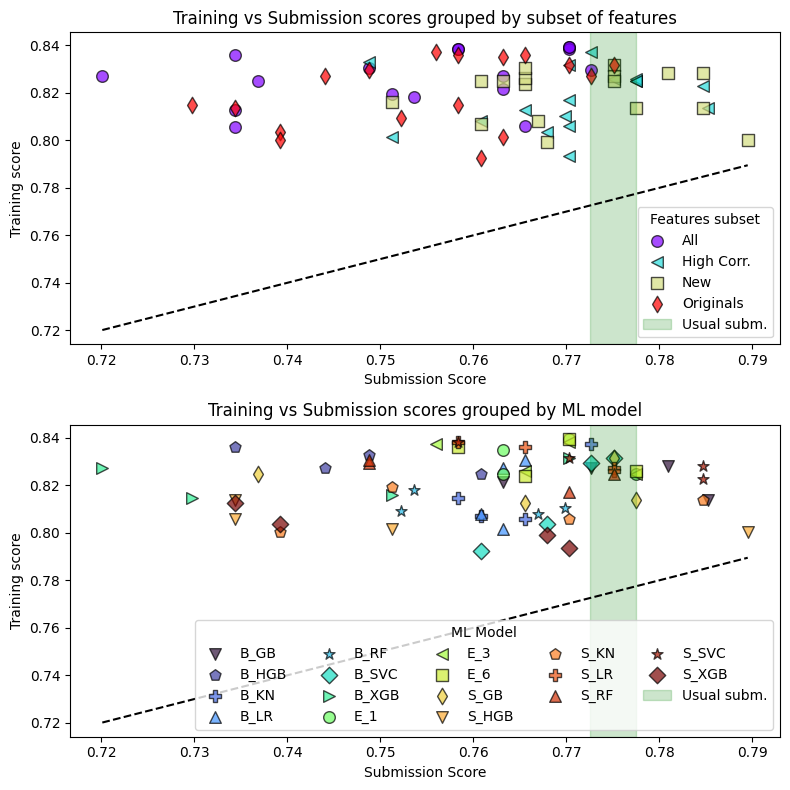

In [57]:
from matplotlib.pyplot import cm

def plot_training_submission_scores(df_results):
    """
    Plot training vs submission scores in two plots, the first one grouped by subsets of features, 
    the second one by ML models.
    --- Inputs ---
    {df_results}. Type: DataFrame. Definition: Results for all trained models, must include the following
    columns: 'Feats_subset','Model_name','train_score','subm_score'.
    """
    # Identify features' subsets and models for the results:
    feat_subsets = sorted(set(df_results['Feats_subset']))
    models = sorted(set(df_results['Model_name']))    
    
    # Plot figures:
    markers = ["o","<","s","d","v","p","P","^","*","D",">"]
    colors_feats = cm.rainbow(np.linspace(0, 1, len(feat_subsets)))
    colors_models = cm.turbo(np.linspace(0, 1, len(models)))
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
    for i,name in enumerate(feat_subsets):
        data = df_results[df_results['Feats_subset']==name]
        ax1.scatter(data['subm_score'],data['train_score'],marker=markers[i % len(markers)],
                    s=70,edgecolor='k',color=colors_feats[i],alpha=0.7,label=name)
    for j,model in enumerate(models):
        data = df_results[df_results['Model_name']==model]
        ax2.scatter(data['subm_score'],data['train_score'],marker=markers[(i+j+1) % len(markers)],
                    s=70,edgecolor='k',color=colors_models[j],alpha=0.7,label=model)    
    range_subm_score = [min(df_results['subm_score']),max(df_results['subm_score'])]
    # Additional configuration:
    for axis in [ax1,ax2]: # Identity line
        axis.axvspan(0.7725, 0.7775, alpha=0.2, color='green',label='Usual subm.')
        axis.plot(range_subm_score,range_subm_score,'--k')
        axis.set(xlabel="Submission Score",ylabel="Training score")
    ax1.legend(title='Features subset')
    ax1.set_title('Training vs Submission scores grouped by subset of features')
    ax2.legend(title='ML Model',ncol=5)
    ax2.set_title('Training vs Submission scores grouped by ML model')
    fig.tight_layout()
    plt.show()
    
plot_training_submission_scores(df1_results)

Results are widely spread, and only a <span style="font-weight:bold;">few ML models score better than the most usual submissions in the Leaderboard</span> (shaded area). I highlight the following observations:

* <span style="font-weight:bold;"><span style="font-style:italic;">Submission scores</span> range between 0.72 and 0.79</span>, with most around 0.76-0.77.

* <span style="font-weight:bold;"><ins>ALL models overfit</ins></span>, meaning that their <span style="font-style:italic;">Training scores</span> are significantly better than their <span style="font-style:italic;">Submission scores</span>. This is a <span style="font-weight:bold;">bad symptom</span>, although very common when training small datasets. <span style="font-weight:bold;">If we were to pick the best Training model, then we would probably make a bad choice</span>. In fact, the best training model, with a <span style="font-style:italic;">Submission score</span> of 0.7895, is one of the worst models if we just look at the <span style="font-style:italic;">Training scores</span>.
  
* The first plot shows that the <span style="font-weight:bold;">best results</span> are only achieved when using either the <ins>New</ins> or <ins>High <span style="font-weight:bold;">Survived</span>-correlation</ins> subsets of features.

* Looking at the second plot, it's easy to identify the few models that stand out, with <span style="font-weight:bold;">scores higher than 0.78</span>: <span style="color:red;font-weight:bold;">S_HGB</span>, <span style="color:green;font-weight:bold;">B_GB</span>, <span style="color:red;font-weight:bold;">S_KN</span> and <span style="color:red;font-weight:bold;">S_SVC</span>.

In the next stage, I will focus on <span style="font-weight:bold;">optimizing these top-performing models</span>, using either the <ins>New</ins> or <ins>High <span style="font-weight:bold;">Survived</span>-correlation</ins> subsets of features.

<hr>

## <font color='teal'>Model optimization</font> <a class="anchor"  id="Model_optimization"></a>

<span style="font-weight:bold;">So far, the best <span style="font-style:italic;">Submission score</span> is 0.7895</span>. Let's try to improve it!

I have to be very careful in this process, as I've already demonstrated that <span style="font-weight:bold;">models tend to overfit</span>. I may optimize a model up to a very high <span style="font-style:italic;">training score</span>, let's say above 0.9, but that doesn't mean that the <span style="font-style:italic;">Submission score</span> will improve as well. <span style="font-weight:bold;">In general, the more overfitting, the worse final performance of the model</span>.

For this reason, <span style="font-weight:bold;">I won't use automated optimizations routines</span> such as GridSearch (which would return the best hyperparameters according to the <span style="font-style:italic;">training scores</span>). Instead, <span style="font-weight:bold;"><ins>I perform a manual search and evaluate all results</ins></span>. The following table describes the <span style="font-weight:bold;">hyperparameters</span> that I'm going to tune, applicable to the <span style="color:green;font-weight:bold;">Basic</span> models (including those in the <span style="color:red;font-weight:bold;">Stacking</span> model), making <span style="font-weight:bold;">all possible combinations</span>:

| Hyperparameter | Applicable Basic models | Options |
| :---: | :---: | :---: |
| <span style="font-weight:bold;">n_estimators</span> | RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, XGBClassifier | 50, 100, 200 |
| <span style="font-weight:bold;">max_depth</span> | RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, XGBClassifier | 3,5,7 |
| <span style="font-weight:bold;">learning_rate</span> | GradientBoostingClassifier, HistGradientBoostingClassifier, XGBClassifier | 0.05, 0.1, 0.2 |
| <span style="font-weight:bold;">n_neighbors</span> | KNeighborsClassifier | 3, 5, 7 |

In [58]:
# Define hyperparameters' options: 
seed = 0 # Set seed for reproducibility
n_estimators = [50,100,200] # Tree-type models (includes gradient-boosting)
max_depth = [3,5,7] # Tree-type models (includes gradient-boosting)
learning_rate = [0.05,0.1,0.2] # Gradient-booting-type:
n_neighbors = [3,5,7] # K-Neighbors-type

# Build all possible combinations:
import itertools
hyps_options = list(itertools.product(*[n_estimators,max_depth,learning_rate,n_neighbors]))

print('Number of hyperparameters combinations:', len(hyps_options))

Number of hyperparameters combinations: 81


<div style="color:black;
           display:fill;
           border-radius:15px;
           background-color:lightgray;
           font-size:100%;
           letter-spacing:0.5px">
    
<p style="padding: 10px;
              color:black;">
    ❗ <span style="color:red;font-weight:bold;">Attention:</span>
    <br>
    If you want to <span style="text-decoration:underline">load the results from my previous run</span>, set <span style="font-weight:bold;">training=False</span> (default option). 
    <br>
    If you want to <span style="text-decoration:underline">run the training</span>, choose <span style="font-weight:bold;">training=True</span>.
    <br>
    Either way should provide the same results, as I'm using programmed seeds to initialize every model.
   </p> 
</div>

In [59]:
def prepare_basic_models(hyps,seed=0):
    """
    Define the Basic models according to the hyperparameters options.
    --- Inputs ---
    {hyps}. Type: List. Definition: Hyperparameters for the Basic models, when applicable,
    in the following order: [n_estimators, max_depth, learning_rate, n_neighbors].
    {seed}. Type: Integer. Definition: Seed for random initialization of each Basic model,
    when applicable.
    --- Outputs ---
    {b_models}. Type: Dictionary. Definition: Each key represents a basic model, its value
    is the Machine Learning model object.
    """
    n_est, max_dep, LR, n_neig = hyps # Prepare hyperparameters
    # Assign hyperparameters to the ML models when applicable.
    b_models = {"B_RF": RandomForestClassifier(n_estimators=n_est,max_depth=max_dep,random_state=seed),
                    "B_LR": LogisticRegression(random_state=seed),
                    "B_GB": GradientBoostingClassifier(n_estimators=n_est,max_depth=max_dep,
                                                       learning_rate=LR,random_state=seed),
                    "B_HGB": HistGradientBoostingClassifier(max_depth=max_dep,learning_rate=LR,
                                                            random_state=seed),
                    "B_XGB": XGBClassifier(n_estimators=n_est,max_depth=max_dep,
                                           learning_rate=LR,random_state=seed),
                    "B_KN": KNeighborsClassifier(n_neighbors=n_neig),
                    "B_SVC": LinearSVC(random_state=seed,dual=False)
                   }
    return b_models

Results sorted by submission scores:


,Feats_subset,Model_name,n_est;max_dep;LR;n_neig,subm_score,train_score
0,High Corr.,S_SVC,"(200, 3, 0.05, 3)",0.7990,0.8283
1,High Corr.,S_SVC,"(100, 3, 0.2, 5)",0.7990,0.8238
2,High Corr.,S_SVC,"(200, 3, 0.05, 5)",0.7990,0.8204
3,High Corr.,S_SVC,"(100, 3, 0.1, 5)",0.7990,0.8204
4,High Corr.,B_GB,"(100, 3, 0.05, 3)",0.7986,0.8137
5,High Corr.,B_GB,"(100, 3, 0.05, 5)",0.7986,0.8137
6,High Corr.,B_GB,"(100, 3, 0.05, 7)",0.7986,0.8137
7,High Corr.,S_SVC,"(100, 3, 0.1, 3)",0.7967,0.8260
8,High Corr.,S_HGB,"(200, 3, 0.1, 7)",0.7967,0.8081
9,High Corr.,S_SVC,"(200, 3, 0.1, 5)",0.7967,0.8204


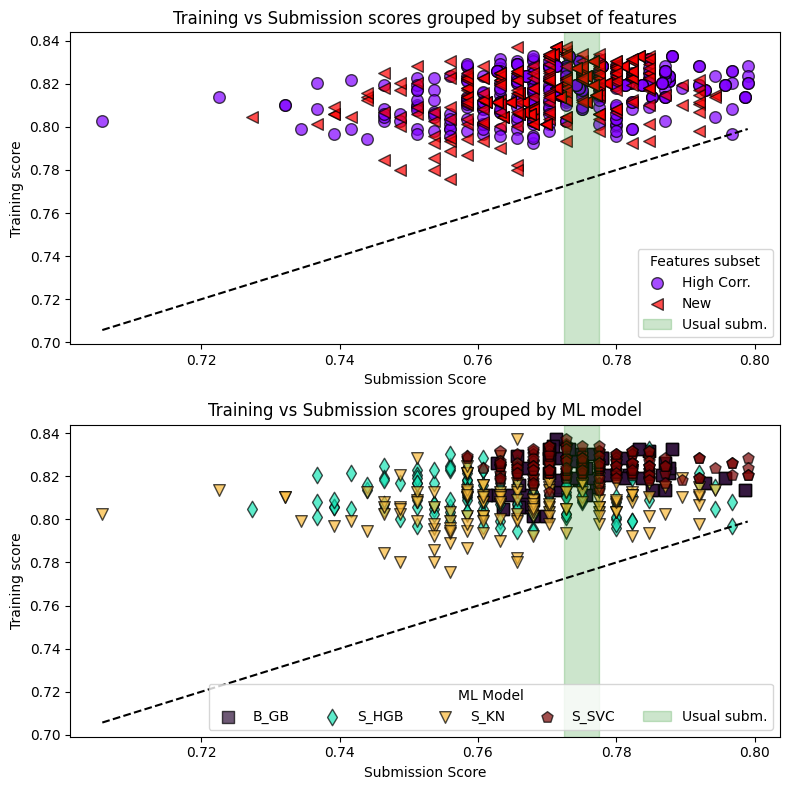

In [61]:
training = False

if training:
    # Prepare dataframe and global parameters:
    df2_results = pd.DataFrame(columns=[
        'Feats_subset','Model_name','n_est;max_dep;LR;n_neig','train_score','train_std','subm_score','subm_std'])
    k_fold = 5 # Instances for cross-validation and for submission
    feats_opts = {'New': feats_new, 'High Corr.': feats_high_corr}
    
    # Define models:
    for hyps in hyps_options:
        # Prepare Basic models:
        b_models = prepare_basic_models(hyps,seed=0) 
        # Prepare Stacking models:
        b_all = [(model,b_models[model]) for model in b_models] # Group all basic models for Stacking        
        s_models = {} # Initialize
        for model in ['B_HGB','B_KN','B_SVC']:
            s_models[f"S_{model[2:]}"] = StackingClassifier(
            estimators=b_all, final_estimator=b_models[model])
        # Combine all models in a single dictionary:
        all_models = {**{"B_GB":b_models["B_GB"]}, **s_models}
        
        # Define subset of features:
        for subset in feats_opts:
            x_train_std, x_test_std = standardize_datasets(train_df_enc,test_df_enc,feats_opts[subset])
    
            # Train and evaluate models:
            for model in all_models:
                avg_score_train, std_score_train, avg_score_test, std_score_test = train_evaluate_models(
                    all_models[model],x_train_std,y_train,x_test_std,y_sol,k_fold)
                # Update dataframe:
                df2_results.loc[len(df2_results)] ={'Feats_subset':subset,
                                                    'Model_name':model,
                                                    'n_est;max_dep;LR;n_neig':hyps,
                                                    'train_score':avg_score_train,
                                                    'train_std':std_score_train,
                                                    'subm_score':avg_score_test,
                                                    'subm_std':std_score_test}    
    # Sort results by subm_score:
    df2_results = df2_results.round(decimals=4) # Round to 4 digits precision, more is unnecesary
    df2_results = df2_results.sort_values(['subm_score'],ascending=False) # Sort
    print('Finished!')
else:
    df2_results = pd.read_csv('titanic-fm/Pretrained_Optimization1_5fold.csv')
print("Results sorted by submission scores:")
display(df2_results[["Feats_subset","Model_name","n_est;max_dep;LR;n_neig","subm_score","train_score"]].head(10))
plot_training_submission_scores(df2_results)

Good news! In the first training stage the best <span style="font-style:italic;;font-weight:bold">Submission score</span> was 0.7895, now it <span style="font-weight:bold;">has increased to 0.7990</span>. Which are the <span style="font-weight:bold;">main insights</span> from this optimization process?

* The subset of features <span style="font-weight:bold;"><ins>High <span style="font-weight:bold;">Survived</span>-correlation</ins> performs better</span>.

* The leading model is <span style="color:red;font-weight:bold;">S_SVC</span>, which achieved the <span style="font-weight:bold;">best results for various hyperparameter configurations</span>.

The <span style="font-weight:bold;">top-performing hyperparameter</span> options include:

* n_estimators = [100,200].
* max_depth = [3]
* learning_rate = [0.05,0.1,0.2].
* n_neighbors = [3,5].

From this first optimization stage, I conclude that is better to <span style="font-weight:bold;">avoid too few n_estimators</span> (50 wasn't enough), to <span style="font-weight:bold;">keep max_depth low</span>, to work with <span style="font-weight:bold;">any learning_rate</span>, and to have <span style="font-weight:bold;">not too many n_neighbors</span> (7 was rejected). Based on these observations, I will <span style="font-weight:bold;">run a second optimization round</span>, only for the <span style="color:red;font-weight:bold;">S_SVC</span> model and the <ins>High <span style="font-weight:bold;">Survived</span>-correlation</ins> subset of features.

<div style="color:black;
           display:fill;
           border-radius:15px;
           background-color:lightgray;
           font-size:100%;
           letter-spacing:0.5px">
    
<p style="padding: 10px;
              color:black;">
    ❗ <span style="color:red;font-weight:bold;">Attention:</span>
    <br>
    If you want to <span style="text-decoration:underline">load the results from my previous run</span>, set <span style="font-weight:bold;">training=False</span> (default option). 
    <br>
    If you want to <span style="text-decoration:underline">run the training</span>, choose <span style="font-weight:bold;">training=True</span>.
    <br>
    Either way should provide the same results, as I'm using programmed seeds to initialize every model.
   </p> 
</div>

In [62]:
# Define hyperparameters' options: 
seed = 0 # Set seed for reproducibility
n_estimators = [100,200,400,600] # Tree-type models (includes gradient-boosting)
max_depth = [2,3,4] # Tree-type models (includes gradient-boosting)
learning_rate = [0.1] # Gradient-booting-type:
n_neighbors = [2,3,4,5] # K-Neighbors-type

# Build all possible combinations:
hyps_options = list(itertools.product(*[n_estimators,max_depth,learning_rate,n_neighbors]))

print('Number of hyperparameters combinations:', len(hyps_options))

Number of hyperparameters combinations: 48


Results sorted by submission scores:


,Feats_subset,Model_name,n_est;max_dep;LR;n_neig,subm_score,train_score
0,High Corr.,S_SVC,"(200, 2, 0.1, 4)",0.7990,0.8216
1,High Corr.,S_SVC,"(100, 3, 0.1, 5)",0.7990,0.8204
2,High Corr.,S_SVC,"(200, 3, 0.1, 4)",0.7990,0.8182
3,High Corr.,S_SVC,"(100, 4, 0.1, 4)",0.7990,0.8204
4,High Corr.,S_SVC,"(400, 2, 0.1, 5)",0.7990,0.8260
5,High Corr.,S_SVC,"(600, 2, 0.1, 5)",0.7990,0.8272
6,High Corr.,S_SVC,"(100, 3, 0.1, 3)",0.7967,0.8260
7,High Corr.,S_SVC,"(200, 2, 0.1, 3)",0.7967,0.8204
8,High Corr.,S_SVC,"(200, 3, 0.1, 5)",0.7967,0.8204
9,High Corr.,S_SVC,"(400, 2, 0.1, 4)",0.7943,0.8204


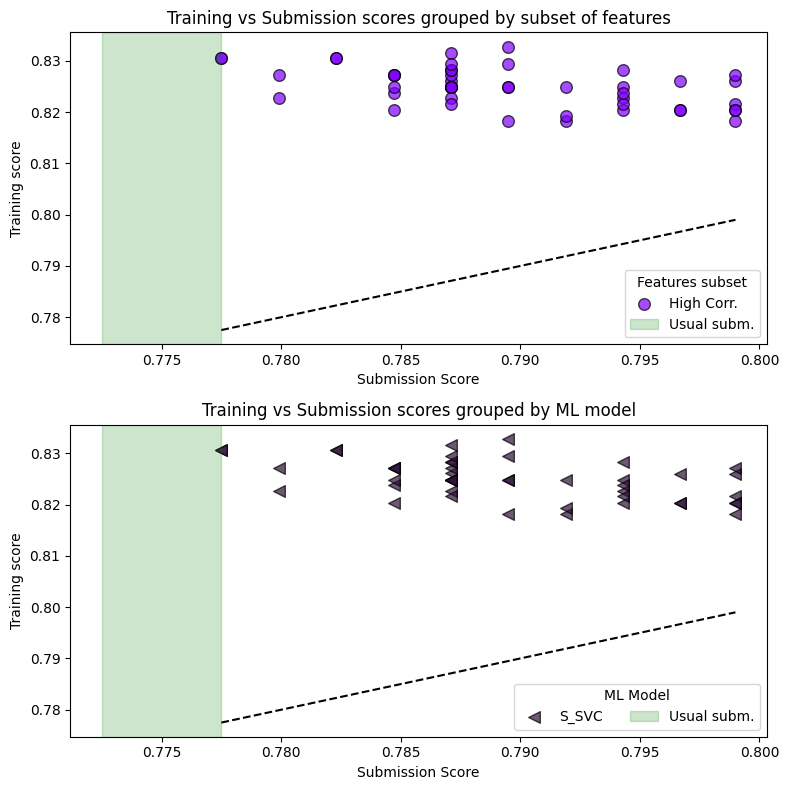

In [64]:
training = False

if training:
    # Prepare dataframe and global parameters:
    df3_results = pd.DataFrame(columns=[
        'Feats_subset','Model_name','n_est;max_dep;LR;n_neig','train_score','train_std','subm_score','subm_std'])
    k_fold = 5 # Instances for cross-validation and for submission
    feats_opts = {'High Corr.': feats_high_corr}
    
    # Define models:
    for hyps in hyps_options:
        # Prepare Basic models:
        b_models = prepare_basic_models(hyps,seed=0) 
        # Prepare Stacking models:
        b_all = [(model,b_models[model]) for model in b_models] # Group all basic models for Stacking
        s_models = {'S_SVC': StackingClassifier(
            estimators=b_all, final_estimator=b_models['B_SVC'])}
        
        # Define subset of features:
        for subset in feats_opts:
            x_train_std, x_test_std = standardize_datasets(train_df_enc,test_df_enc,feats_opts[subset])
    
            # Train and evaluate models:
            for model in s_models:
                avg_score_train, std_score_train, avg_score_test, std_score_test = train_evaluate_models(
                    s_models[model],x_train_std,y_train,x_test_std,y_sol,k_fold)
                # Update dataframe:
                df3_results.loc[len(df3_results)] ={'Feats_subset':subset,
                                                    'Model_name':model,
                                                    'n_est;max_dep;LR;n_neig': hyps,
                                                    'train_score':avg_score_train,
                                                    'train_std':std_score_train,
                                                    'subm_score':avg_score_test,
                                                    'subm_std':std_score_test}    
    # Sort results by subm_score:
    df3_results = df3_results.round(decimals=4) # Round to 4 digits precision, more is unnecesary
    df3_results = df3_results.sort_values(['subm_score'],ascending=False) # Sort
    print('Finished!')
else:
    df3_results = pd.read_csv('titanic-fm/Pretrained_Optimization2_5fold.csv')
print("Results sorted by submission scores:")
display(df3_results[["Feats_subset","Model_name","n_est;max_dep;LR;n_neig","subm_score","train_score"]].head(10))
plot_training_submission_scores(df3_results)

This time, there are <span style="font-weight:bold;">no improvements in the <span style="font-style:italic;">Submission scores</span></span> compared to the previous 0.7990 result. However, this analysis demonstrates that the <span style="color:red;font-weight:bold;">S_SVC</span> Stacking model is <span style="font-weight:bold;">very robust</span>, with scores ranging from 0.78 to 0.80. The top models table shows that 6 of them have <span style="font-weight:bold;">equal performance with very different combinations of hyperparameters</span>. In fact, all available options appear at least once, with the exception of n_neighbors=[2,3]. Therefore, I consider that the <span style="font-weight:bold;">optimization process has reached its limit</span> for this model.

I'm certain that <span style="font-weight:bold;">there is room for improvement</span>, for example by expanding the hyperparameters search or considering different combinations of <span style="color:green;font-weight:bold;">Basic</span> ML models. However, <span style="font-weight:bold;">I don't expect these efforts to significant enhance the model's performance</span> to, let's say, a <span style="font-style:italic;">Submission score</span> of 0.82. In other words, after an extensive search I might achieve a 0.80 <span style="font-style:italic;">Submission score</span>, but this wouldn't constitute a fundamental advancement. 

The <span style="font-weight:bold;">real progress</span>, as I see it, lies in developing <span style="font-weight:bold;">new ideas for feature engineering, machine learning modeling or hyperparameter strategies</span>, bringing original and unlocking a full range of improvements. In particular, I think that <ins><span style="color:navy;font-weight:bold;">solving the overfitting problem</span></ins> <span style="font-weight:bold;">is the key, as the training process would become more reliable</span>. I leave that challenge to the reader!

<hr>

# <font color='teal'>Section IV: Conclusions</font> <a class="anchor"  id="Section_IV"></a>

We've reached the end of our journey, I'm very happy to share my thoughts with you and hope you enjoyed it. I encourage you to <span style="font-weight:bold;">share your own perspectives, suggestions and ideas, any feedback is very welcome!</span>

The next lines prepare the <span style="font-weight:bold;">best model</span> for the <span style="color:navy;font-weight:bold;">competition Submission</span>, so you can check the final score.

Thanks a lot for your attention!

In [65]:
# Select subset of features and hyperparameters:
subset = feats_high_corr
hyps = [200, 2, 0.1, 4]

# Prepare the model:
b_models = prepare_basic_models(hyps,seed=0) 
b_all = [(model,b_models[model]) for model in b_models] # Group all basic models for Stacking
s_model = StackingClassifier(estimators=b_all, final_estimator=b_models['B_SVC'])
# Prepare data:    
x_train_std, x_test_std = standardize_datasets(train_df_enc,test_df_enc,subset)
# Train the model:
s_model.fit(x_train_std,y_train)
# Make predictions for the test dataset and prepare for submission:
preds = s_model.predict(x_test_std)
df_subm = pd.DataFrame({
        "PassengerId": passID_test,
        "Survived": preds
    }).to_csv('submission.csv', index=False)
# Display the score according to the Solution file:
print("Anticipated submission score:",sum(preds == y_sol)/len(y_sol))

Anticipated submission score: 0.7990430622009569
